# Bài tập lớn: Phân tích tương tác và nội dung của một tài khoản Tiktok
Môn học: Lập trình xử lý dữ liệu với Python.
Thành viên:
- Chu Thị Phương Anh.
- Phạm Hà Anh.
- Tô Tiến Đạt.

# Phần 1: Xử lý dữ liệu (Data Cleaning)

Tải các thư viện cần để xử lý dữ liệu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import hashlib
import ast
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import random
from ast import literal_eval
from time import sleep
from datetime import datetime
from ast import literal_eval
import numpy as np
import csv
import os
import re

Đọc file dữ liệu

In [2]:
read_df = pd.read_csv('Data/data.csv',  encoding='ISO-8859-1')

In [3]:
read_df.info()
# ⇒ Dữ liệu chúng ta thu thập được sẽ có 863 bài post và có 80 cột dữ liệu được kéo về

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 80 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/bioLink                        0 non-null      float64
 2   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 3   authorMeta/digg                           863 non-null    int64  
 4   authorMeta/fans                           863 non-null    int64  
 5   authorMeta/following                      863 non-null    int64  
 6   authorMeta/friends                        863 non-null    int64  
 7   authorMeta/heart                          863 non-null    int64  
 8   authorMeta/id                             863 non-null    int64  
 9   authorMeta/name                           863 non-null    object 
 10  authorMeta/nickName                   

In [4]:
# Tiếp tục với quá trình xử lý dữ liệu, chúng ta sẽ xóa đi những cột có giá trị null hoàn toàn 
read_df = read_df.dropna(axis='columns', how='all')

In [5]:
# ⇒ Với cách này chúng ta đã loại bỏ đi được 2 cột dữ liệu không có giá trị phân tích 
# => Còn lại 78 cột
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 78 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

In [6]:
# Tính tỷ lệ giá trị null cho mỗi cột
Null_Percentage = read_df.isnull().mean()

# Lấy các cột có tỷ lệ giá trị null lớn hơn 99%
Null_more_ninety = Null_Percentage[Null_Percentage > 0.99].index

# Xóa các cột có tỷ lệ giá trị null lớn hơn 99%
read_df = read_df.drop(columns=Null_more_ninety)

In [7]:
# ⇒ Với cách này chúng ta đã loại bỏ đi được 12 cột dữ liệu không có giá trị phân tích 
# => Còn 66 cột
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

In [8]:
# Lấy các cột có tỷ lệ giá trị null lớn hơn 50% và bé hơn 99%
Null_Percentage[(Null_Percentage > 0.5) & (Null_Percentage < 0.99)].index

Index(['detailedMentions/0/id', 'detailedMentions/0/nickName',
       'detailedMentions/0/profileUrl', 'detailedMentions/1/id',
       'detailedMentions/1/name', 'detailedMentions/1/nickName',
       'detailedMentions/1/profileUrl', 'hashtags/3/name', 'hashtags/4/name',
       'hashtags/5/name', 'hashtags/6/name', 'hashtags/7/name', 'mentions/0',
       'mentions/1', 'videoMeta/subtitleLinks/0/downloadLink',
       'videoMeta/subtitleLinks/0/language',
       'videoMeta/subtitleLinks/0/tiktokLink'],
      dtype='object')

## **Xóa các cột chứa đường link**

## 1. Cột 'videoMeta/subtitleLinks/0/tiktokLink'

In [9]:
# # Ở đây chúng ta sẽ có một số các cột chứa các đường link,
# #  chúng ta sẽ kiểm tra xem các đường link đó có truy cập được không nếu không thì chúng ta sẽ xóa nó đi 


import pandas as pd
import hashlib
import numpy as np
import httpx
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Hàm kiểm tra link
def check_link(link, expected_hash_value):
    try:
        with httpx.Client(timeout=5) as client:
            response = client.get(link)
        if response.status_code == 200:
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()
            if sha256_hash == expected_hash_value:
                return link
    except (httpx.RequestError, httpx.TimeoutException):
        pass
    return np.nan

# Hàm xử lý song song với tiến trình
def process_links(links, expected_hash_value):
    with ThreadPoolExecutor(max_workers=min(10, len(links))) as executor:
        results = list(tqdm(executor.map(lambda link: check_link(link, expected_hash_value), links), total=len(links)))
    return results

# Lọc các giá trị hợp lệ
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
valid_links = read_df['videoMeta/subtitleLinks/0/tiktokLink'].dropna()

# Xử lý các giá trị hợp lệ
processed_links = process_links(valid_links, expected_hash_value)

# Tạo một bản sao cột để lưu kết quả
processed_column = read_df['videoMeta/subtitleLinks/0/tiktokLink'].copy()

# Gán kết quả đã xử lý vào đúng vị trí
processed_column.loc[valid_links.index] = processed_links

# Cập nhật cột trong DataFrame
read_df['videoMeta/subtitleLinks/0/tiktokLink'] = processed_column

# Kiểm tra và loại bỏ cột nếu cần
if not read_df['videoMeta/subtitleLinks/0/tiktokLink'].isna().all():
    read_df.drop(columns=['videoMeta/subtitleLinks/0/tiktokLink'], inplace=True)


100%|██████████| 408/408 [00:57<00:00,  7.05it/s]


In [10]:
if 'videoMeta/subtitleLinks/0/tiktokLink' in read_df.columns:  # Đảm bảo cột tồn tại
    video_null_ratio = Null_Percentage['videoMeta/subtitleLinks/0/tiktokLink']  # Tỷ lệ NaN trong cột 'video'
    
    # Điều kiện: Tỷ lệ NaN > 99% hoặc = 0%
    if video_null_ratio > 0.99 or video_null_ratio == 0:
        columns_to_drop = ['videoMeta/subtitleLinks/0/tiktokLink', 'videoMeta/subtitleLinks/0/tiktokLink_valid']
        read_df = read_df.drop(columns=[col for col in columns_to_drop if col in read_df.columns])

In [11]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

## 2. Cột 'videoMeta/subtitleLinks/0/downloadLink'

In [12]:
print(read_df.columns.tolist())

['ï»¿"authorMeta/avatar"', 'authorMeta/commerceUserInfo/commerceUser', 'authorMeta/digg', 'authorMeta/fans', 'authorMeta/following', 'authorMeta/friends', 'authorMeta/heart', 'authorMeta/id', 'authorMeta/name', 'authorMeta/nickName', 'authorMeta/originalAvatarUrl', 'authorMeta/privateAccount', 'authorMeta/profileUrl', 'authorMeta/region', 'authorMeta/signature', 'authorMeta/ttSeller', 'authorMeta/verified', 'authorMeta/video', 'collectCount', 'commentCount', 'createTime', 'createTimeISO', 'detailedMentions/0/id', 'detailedMentions/0/nickName', 'detailedMentions/0/profileUrl', 'detailedMentions/1/id', 'detailedMentions/1/name', 'detailedMentions/1/nickName', 'detailedMentions/1/profileUrl', 'diggCount', 'hashtags/0/name', 'hashtags/1/name', 'hashtags/2/name', 'hashtags/3/name', 'hashtags/4/name', 'hashtags/5/name', 'hashtags/6/name', 'hashtags/7/name', 'id', 'input', 'isPinned', 'isSlideshow', 'isSponsored', 'mentions/0', 'mentions/1', 'musicMeta/coverMediumUrl', 'musicMeta/musicAuthor'

In [13]:
import pandas as pd
import hashlib
import numpy as np
import httpx
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Hàm kiểm tra link
def check_link(link, expected_hash_value):
    try:
        with httpx.Client(timeout=5) as client:
            response = client.get(link)
        if response.status_code == 200:
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()
            if sha256_hash == expected_hash_value:
                return link
    except (httpx.RequestError, httpx.TimeoutException):
        pass
    return np.nan

# Hàm xử lý song song với tiến trình
def process_links(links, expected_hash_value):
    with ThreadPoolExecutor(max_workers=min(10, len(links))) as executor:
        results = list(tqdm(executor.map(lambda link: check_link(link, expected_hash_value), links), total=len(links)))
    return results

# Lọc các giá trị hợp lệ
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
valid_links = read_df['videoMeta/subtitleLinks/0/downloadLink'].dropna()

# Xử lý các giá trị hợp lệ
processed_links = process_links(valid_links, expected_hash_value)

# Tạo một bản sao cột để lưu kết quả
processed_column = read_df['videoMeta/subtitleLinks/0/downloadLink'].copy()

# Gán kết quả đã xử lý vào đúng vị trí
processed_column.loc[valid_links.index] = processed_links

# Cập nhật cột trong DataFrame
read_df['videoMeta/subtitleLinks/0/downloadLink'] = processed_column

# Kiểm tra và loại bỏ cột nếu cần
if not read_df['videoMeta/subtitleLinks/0/downloadLink'].isna().all():
    read_df.drop(columns=['videoMeta/subtitleLinks/0/downloadLink'], inplace=True)


100%|██████████| 408/408 [00:55<00:00,  7.41it/s]


In [14]:
# ⇒ Kết quả của cột này vẫn là False ⇒ Xóa cột này đi 

columns_to_drop = ['videoMeta/subtitleLinks/0/downloadLink', 'videoMeta/subtitleLinks/0/downloadLink_valid']
read_df = read_df.drop(columns=[col for col in columns_to_drop if col in read_df.columns])

In [15]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 65 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

## 3. Đối với các cột khác chúng ta sẽ kiểm tra dữ liệu của từng cột và đánh giá xem dữ liệu trong cột đó có sử dụng được hay có giá trị hay không

Dựa vào Index(['detailedMentions/0/id', 'detailedMentions/0/nickName',
       'detailedMentions/0/profileUrl', 'detailedMentions/1/id',
       'detailedMentions/1/name', 'detailedMentions/1/nickName',
       'detailedMentions/1/profileUrl', 'hashtags/3/name', 'hashtags/4/name',
       'hashtags/5/name', 'hashtags/6/name', 'hashtags/7/name', 'mentions/0',
       'mentions/1',
       'videoMeta/subtitleLinks/0/language',],
      dtype='object')

In [16]:
read_df['detailedMentions/0/id'].dropna().head(200)

# Dữ liệu ở cột này không có giá trị phân tích => Cột này sẽ bị xóa
read_df = read_df.drop(columns = 'detailedMentions/0/id')

In [17]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 64 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

**Tương tự với các cột 'detailedMentions/0/nickName',
       'detailedMentions/0/profileUrl', 'detailedMentions/1/id',
       'detailedMentions/1/name', 'detailedMentions/1/nickName',
       'detailedMentions/1/profileUrl', 'hashtags/3/name', 'hashtags/4/name',
       'hashtags/5/name', 'hashtags/6/name', 'hashtags/7/name', 'mentions/0',
       'mentions/1',**

In [18]:
coloumns_drop_many = ['detailedMentions/0/nickName',
       'detailedMentions/0/profileUrl', 
       'detailedMentions/1/id',
       'detailedMentions/1/name', 
       'detailedMentions/1/nickName',
       'detailedMentions/1/profileUrl', 
       'hashtags/3/name', 'hashtags/4/name',
       'hashtags/5/name', 'hashtags/6/name', 
       'hashtags/7/name', 'mentions/0',
       'mentions/1',
       'videoMeta/subtitleLinks/0/language']

read_df = read_df.drop(columns=coloumns_drop_many)

In [19]:
# => Còn 49 cột
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 50 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   ï»¿"authorMeta/avatar"                    863 non-null    object
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool  
 2   authorMeta/digg                           863 non-null    int64 
 3   authorMeta/fans                           863 non-null    int64 
 4   authorMeta/following                      863 non-null    int64 
 5   authorMeta/friends                        863 non-null    int64 
 6   authorMeta/heart                          863 non-null    int64 
 7   authorMeta/id                             863 non-null    int64 
 8   authorMeta/name                           863 non-null    object
 9   authorMeta/nickName                       863 non-null    object
 10  authorMeta/originalAvatarUrl              863 non-

In [20]:
read_df["ï»¿\"authorMeta/avatar\""].dropna().head(200)
#Dữ liệu dẫn đến link avatar của chủ sở hữu
# => Xóa
read_df = read_df.drop(columns="ï»¿\"authorMeta/avatar\"")

In [21]:
read_df["authorMeta/commerceUserInfo/commerceUser"].dropna().head(200)
#Dữ liệu chỉ toàn giá trị False
# => Xóa vì không có giá trị phân tích
read_df = read_df.drop(columns="authorMeta/commerceUserInfo/commerceUser")

In [22]:
read_df["authorMeta/digg"].dropna().head(200)
#Dữ liệu chỉ toàn giá trị 0
# => Xóa vì không có giá trị phân tích
read_df = read_df.drop(columns="authorMeta/digg")

In [23]:
#Loại bỏ các cột có dữ liệu bất biến
for col in read_df.columns:
    if read_df[col].nunique() == 1:
        read_df = read_df.drop(columns=col)

read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   collectCount                          863 non-null    int64 
 1   commentCount                          863 non-null    int64 
 2   createTime                            863 non-null    int64 
 3   createTimeISO                         863 non-null    object
 4   diggCount                             863 non-null    int64 
 5   hashtags/0/name                       835 non-null    object
 6   hashtags/1/name                       813 non-null    object
 7   hashtags/2/name                       674 non-null    object
 8   id                                    863 non-null    int64 
 9   musicMeta/coverMediumUrl              863 non-null    object
 10  musicMeta/musicAuthor                 863 non-null    object
 11  musicMeta/musicId               

In [24]:
coloumns_drop_many = ['musicMeta/coverMediumUrl','musicMeta/musicId',
                      'musicMeta/musicName','musicMeta/originalCoverMediumUrl','musicMeta/playUrl']
#Tương tự với các cột có dữ liệu không thể phân tích được của tag musicMeta
read_df = read_df.drop(columns=coloumns_drop_many)

In [25]:
coloumns_drop_many = ['videoMeta/coverUrl','videoMeta/definition',
                      'videoMeta/height','videoMeta/originalCoverUrl','videoMeta/width']
#Tương tự với các cột có dữ liệu không thể phân tích được của tag videoMeta
read_df = read_df.drop(columns=coloumns_drop_many)

In [26]:
read_df["id"].dropna().head(200)
#Dữ liệu là các con số
# => Xóa vì không có giá trị phân tích
read_df = read_df.drop(columns="id")

In [27]:
read_df["webVideoUrl"].dropna().head(200)
#Dữ liệu là các con số
# => Xóa vì không có giá trị phân tích
read_df = read_df.drop(columns="webVideoUrl")

In [28]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   collectCount                          863 non-null    int64 
 1   commentCount                          863 non-null    int64 
 2   createTime                            863 non-null    int64 
 3   createTimeISO                         863 non-null    object
 4   diggCount                             863 non-null    int64 
 5   hashtags/0/name                       835 non-null    object
 6   hashtags/1/name                       813 non-null    object
 7   hashtags/2/name                       674 non-null    object
 8   musicMeta/musicAuthor                 863 non-null    object
 9   playCount                             863 non-null    int64 
 10  shareCount                            863 non-null    int64 
 11  text                            

Chuyển dữ liệu thời gian về định dạng chuẩn

In [29]:
from datetime import datetime
from dateutil import parser
import pytz
vietnam_tz = pytz.timezone("Asia/Ho_Chi_Minh")
read_df['createTimeISO'] = read_df['createTimeISO'].astype(str)
read_df['createTimeISO'] = read_df['createTimeISO'].apply(
    lambda x: parser.isoparse(x).astimezone(vietnam_tz)
)
read_df['createTimeISO'] = read_df['createTimeISO'].astype(str)

read_df['createTimeISO'] = read_df['createTimeISO'].apply(
    lambda x: datetime.fromisoformat(x).astimezone(vietnam_tz)
)
read_df['date'] = read_df['createTimeISO'].apply(lambda x: x.date())  # Chỉ lấy ngày
read_df['hour'] = read_df['createTimeISO'].apply(lambda x: x.hour)   # Chỉ lấy giờ
read_df['year'] = read_df['date'].apply(lambda x: x.year)
read_df['month'] = read_df['date'].apply(lambda x: x.month)
read_df['day'] = read_df['date'].apply(lambda x: x.day)
read_df.drop(columns=['createTimeISO', 'date'])


,collectCount,commentCount,createTime,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,shareCount,text,videoMeta/duration,videoMeta/subtitleLinks/0/tiktokLink,hour,year,month,day
0,1392,231,1732165470,26900,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,499600,299,4 Vá» TÆ°á»ng CÃºi Äáº§u TrÆ°á»c 1 Vá» Tr...,108,NaN,12,2024,11,21
1,275,45,1731913011,3128,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,33600,203,Lá»ch Sá»­ NgÃ y NhÃ GiÃ¡o Viá»t Nam 20/11....,47,NaN,13,2024,11,18
2,184,34,1731554729,3192,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,36300,31,Chiáº¿c MÅ© Huyá»n Thoáº¡i Cá»§a Ãng Cha. ...,87,NaN,10,2024,11,14
3,691,226,1731216293,17700,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,305200,176,"Máº¹ Thá»©, HÆ¡n Cáº£ Sá»± VÄ© Äáº¡i ... #...",75,NaN,12,2024,11,10
4,1544,708,1730886398,38300,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,1000000,364,PhÃ©p MÃ u Viá»t Nam ... #dongmauviet,88,NaN,16,2024,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,641,2285,1621612142,150200,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,1300000,1064,Má»i ngÆ°á»i vÃ o kÃªnh youtube : dÃ²ng mÃ¡u...,107,NaN,22,2021,5,21
859,125,282,1621556153,16200,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,145000,155,Xin má»i ngÆ°á»i 1 bÃ¬nh luáº­n Äá» kÃªnh ...,159,NaN,7,2021,5,21
860,407,1195,1621471433,73700,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,434800,293,Xin má»i ngÆ°á»i 1 cháº¥m vÃ o bÃ¬nh luáº­n ...,68,NaN,7,2021,5,20
861,248,77,1621385927,14000,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,139000,138,Má»i ngÆ°á»i cho mÃ¬nh xin 1 cháº¥m vÃ o bÃ¬...,58,NaN,7,2021,5,19


Tạo cột text_lenght bao gồm số lượng kí tự của text

In [30]:
read_df['text']=read_df['text'].astype(str)
read_df['text_length']=read_df['text'].apply(lambda x: len(list(x.split(" "))))

Chỉnh text về lỗi về đúng định dạng chữ tiếng Việt

In [31]:
read_df['text']= read_df['text'].apply(lambda x: x.encode('latin1').decode('utf-8'))
read_df['text'].dropna().head(200)

0      4 Vị Tướng Cúi Đầu Trước 1 Vị Trung Tá.   #don...
1      Lịch Sử Ngày Nhà Giáo Việt Nam 20/11.  #dongma...
2      Chiếc Mũ Huyền Thoại Của Ông Cha.   #dongmauviet 
3          Mẹ Thứ, Hơn Cả Sự Vĩ Đại ...    #dongmauviet 
4                  Phép Màu Việt Nam ...   #dongmauviet 
                             ...                        
195          #dongmauviet #dcgr #vietnam #lichsuvietnam 
196          #dongmauviet #dcgr #vietnam #lichsuvietnam 
197                         #dongmauviet #dcgr #vietnam 
198          #dongmauviet #dcgr #vietnam #lichsuvietnam 
199                         #dongmauviet #dcgr #vietnam 
Name: text, Length: 200, dtype: object

# II. Khám phá dữ liệu (Data Exploration)

## 1. Về xu hướng đăng bài của tài khoản

### 1.1 Tần suất đăng bài

Trung bình: 123.28571428571429
Độ lệch chuẩn tổng thể: 9.735271449943324


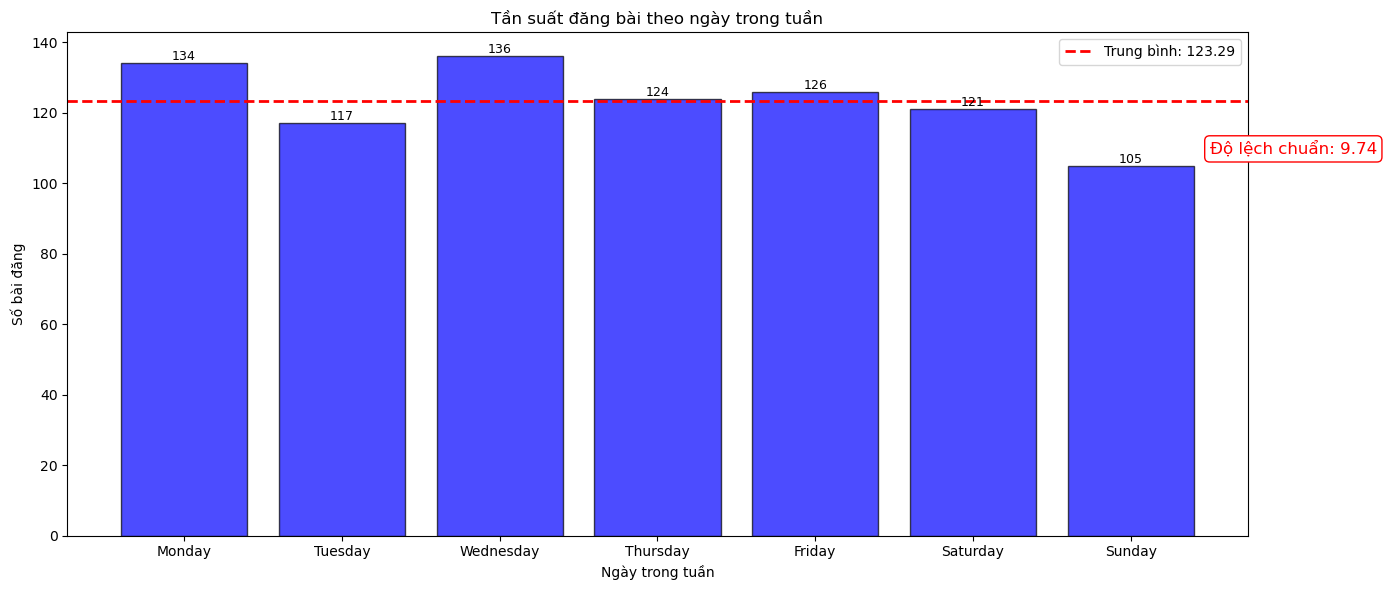

In [32]:
# Bước 1: Tạo cột 'date' từ 3 cột riêng biệt
read_df['date'] = pd.to_datetime(read_df[['year', 'month', 'day']])

# Bước 2: Trích xuất ngày trong tuần
read_df['day_of_week'] = read_df['date'].dt.day_name()

# Bước 3: Tính tần suất bài đăng theo ngày trong tuần
day_counts = read_df['day_of_week'].value_counts()

# Sắp xếp thứ tự các ngày trong tuần
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(days_of_week, fill_value=0)

# Bước 4: Dữ liệu trung bình và độ lệch chuẩn
data = pd.Series([134, 117, 136, 124, 126, 121, 105])
# Tính trung bình
mean = data.mean()
print("Trung bình:", mean)
population_std = np.std(data)
print("Độ lệch chuẩn tổng thể:", population_std)

# Bước 5: Vẽ biểu đồ cột
fig, day_plot = plt.subplots(figsize=(14, 6))

day_plot.bar(days_of_week, day_counts, color='blue', alpha=0.7, edgecolor='black')

# Vẽ đường trung bình
day_plot.axhline(mean, color='red', linestyle='--', linewidth=2, label=f"Trung bình: {mean:.2f}")

# Tùy chỉnh trục và nhãn
day_plot.set_xlabel('Ngày trong tuần')
day_plot.set_ylabel('Số bài đăng')
day_plot.set_title('Tần suất đăng bài theo ngày trong tuần')

# Hiển thị giá trị trên các cột
for i, count in enumerate(day_counts):
    day_plot.text(i, count, int(count), ha='center', va='bottom', fontsize=9, color='black')

# Thêm chú thích độ lệch chuẩn bên cạnh đường trung bình, không chồng lấn
plt.text(
    6.5, mean - 15, f"Độ lệch chuẩn: {population_std:.2f}", color='red', fontsize=12, 
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3')
)

# Hiển thị chú thích
day_plot.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

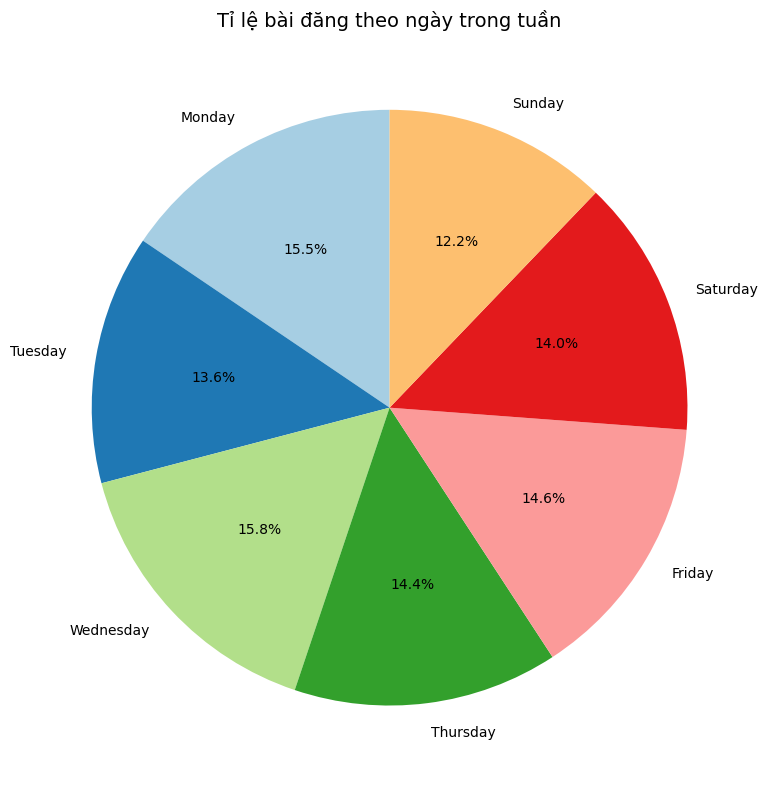

In [33]:
# Bước 1: Tạo cột 'date' từ 3 cột riêng biệt
read_df['date'] = pd.to_datetime(read_df[['year', 'month', 'day']])

# Bước 2: Trích xuất ngày trong tuần
read_df['day_of_week'] = read_df['date'].dt.day_name()

# Bước 3: Tính tần suất bài đăng theo ngày trong tuần
day_counts = read_df['day_of_week'].value_counts()

# Sắp xếp thứ tự các ngày trong tuần
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(days_of_week, fill_value=0)

# Bước 4: Vẽ biểu đồ tròn
fig, ax = plt.subplots(figsize=(8, 8))
colors = plt.cm.Paired(range(len(days_of_week)))  # Tùy chọn bảng màu

# Tạo biểu đồ tròn
ax.pie(
    day_counts, 
    labels=days_of_week, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors, 
    textprops={'fontsize': 10}
)

# Tiêu đề
ax.set_title('Tỉ lệ bài đăng theo ngày trong tuần', fontsize=14)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

- Giá trị trung bình là 123.29 bài
- Độ lệch chuẩn là 9.74 cho thấy dữ liệu không quá biến động, nghĩa là tần suất đăng bài giữa các ngày khá ổn định
- Ngày có số lượng đăng bài cao nhất: Wednesday với 136 bài
- Ngày có số lượng đăng bài thấp nhất: Sunday với 105 bài
- Các ngày giữa tuần (Monday đến Friday) thường có số lượng bài đăng cao hơn so với cuối tuần (Saturday và Sunday)

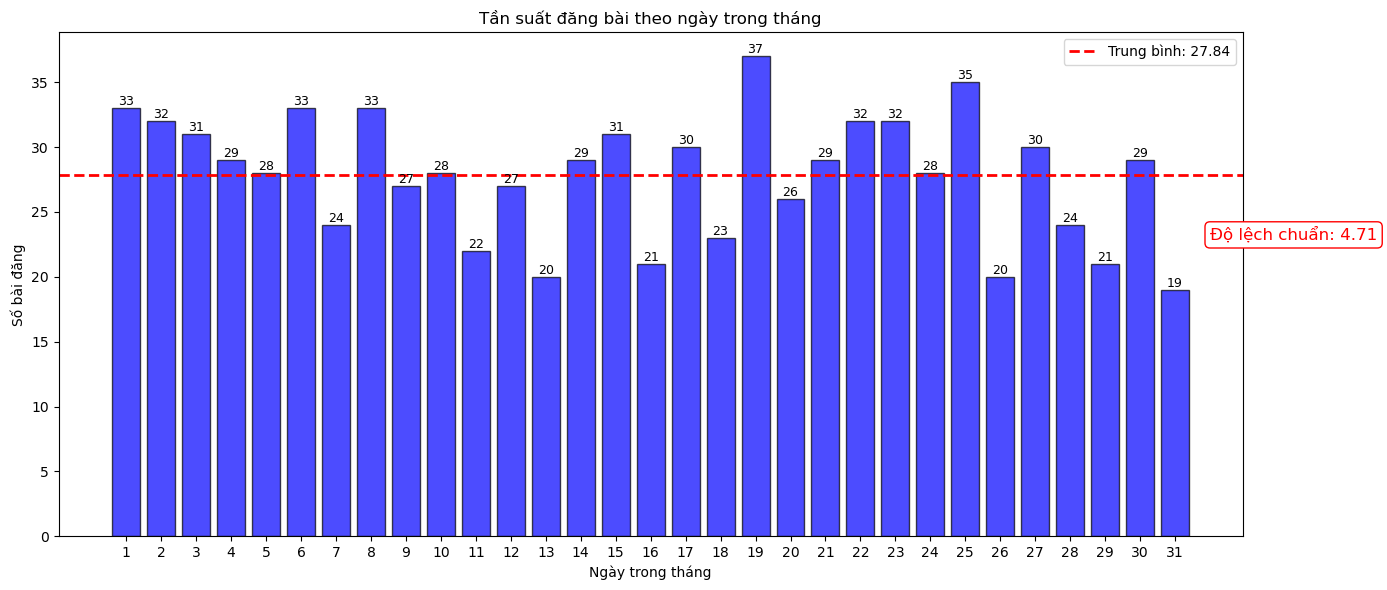

In [34]:
# Bước 1: Tạo cột 'date' từ 3 cột riêng biệt
read_df['date'] = pd.to_datetime(read_df[['year', 'month', 'day']])

# Bước 2: Trích xuất ngày trong tháng
read_df['day_of_month'] = read_df['date'].dt.day

# Bước 3: Tính tần suất bài đăng theo ngày trong tháng
day_counts = read_df['day_of_month'].value_counts().sort_index()

# Bước 4: Tính trung bình và độ lệch chuẩn
mean = day_counts.mean()
population_std = np.std(day_counts)

# Bước 5: Vẽ biểu đồ cột
fig, day_plot = plt.subplots(figsize=(14, 6))

day_plot.bar(day_counts.index, day_counts, color='blue', alpha=0.7, edgecolor='black')

# Vẽ đường trung bình
day_plot.axhline(mean, color='red', linestyle='--', linewidth=2, label=f"Trung bình: {mean:.2f}")

# Tùy chỉnh trục và nhãn
day_plot.set_xlabel('Ngày trong tháng')
day_plot.set_ylabel('Số bài đăng')
day_plot.set_title('Tần suất đăng bài theo ngày trong tháng')
day_plot.set_xticks(day_counts.index)  # Hiển thị tất cả các ngày trong tháng

# Hiển thị giá trị trên các cột
for i, count in enumerate(day_counts):
    day_plot.text(i + 1, count, int(count), ha='center', va='bottom', fontsize=9, color='black')

# Thêm chú thích độ lệch chuẩn bên cạnh đường trung bình, không chồng lấn
plt.text(
    max(day_counts.index) + 1, mean - 5, f"Độ lệch chuẩn: {population_std:.2f}", color='red', fontsize=12, 
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3')
)

# Hiển thị chú thích
day_plot.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

Trung bình số bài đăng theo ngày: 1.27
Độ lệch chuẩn của số bài đăng theo ngày: 0.49
Trung vị số bài đăng theo ngày: 1.00
Số bài đăng ngày cao nhất: 3
Số bài đăng ngày thấp nhất: 1


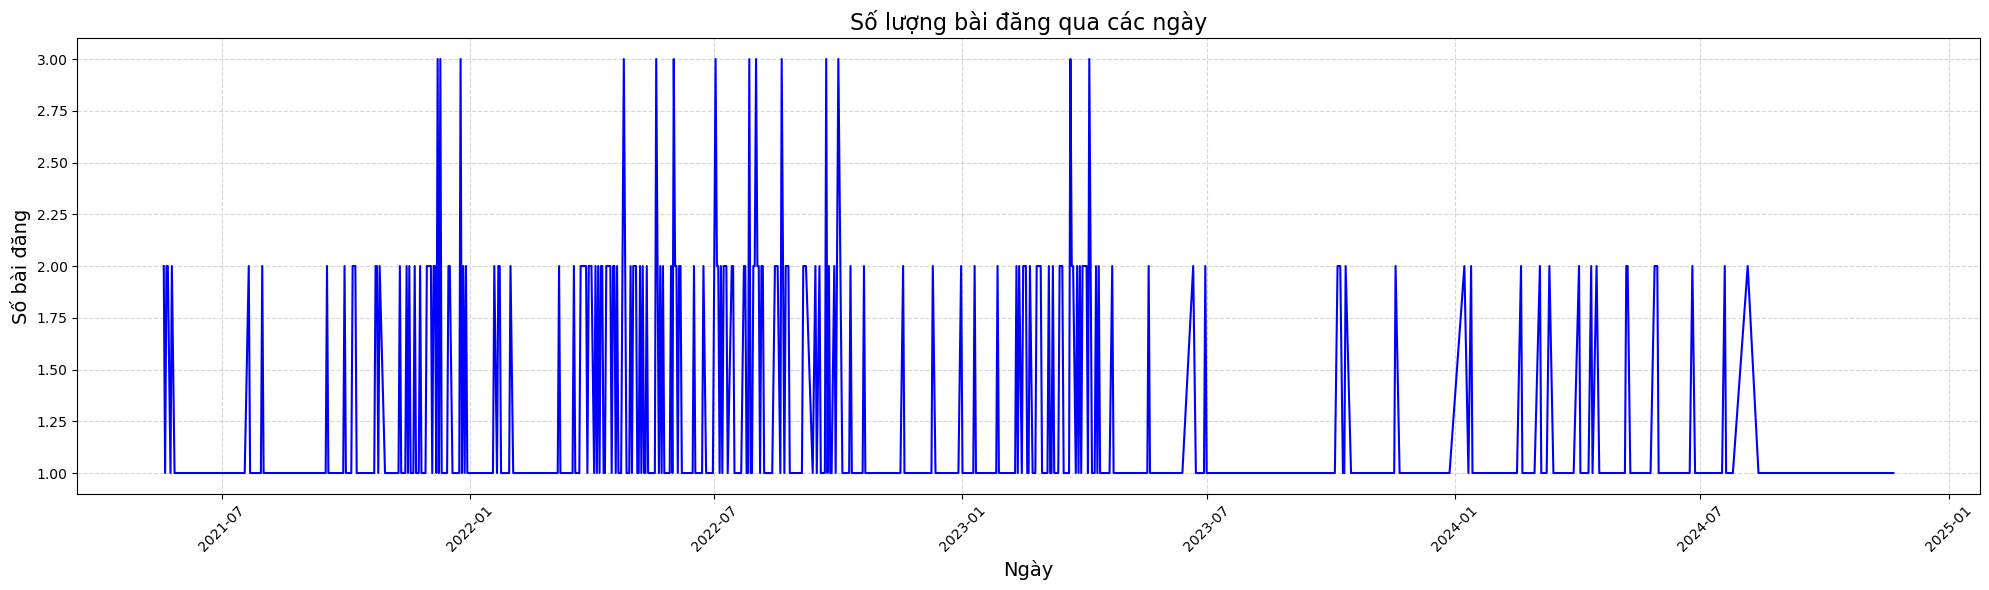

In [35]:
# Bước 1: Tạo cột 'date' từ 3 cột riêng biệt
read_df['date'] = pd.to_datetime(read_df[['year', 'month', 'day']])

# Bước 2: Đếm số lượng bài đăng theo từng ngày
daily_counts = read_df.groupby('date').size().reset_index(name='post_count')

# Tính toán các chỉ số: trung bình, độ lệch chuẩn, trung vị, cao nhất và thấp nhất
mean_posts = daily_counts['post_count'].mean()  # Trung bình
std_posts = daily_counts['post_count'].std()    # Độ lệch chuẩn
median_posts = daily_counts['post_count'].median()  # Trung vị
max_posts = daily_counts['post_count'].max()  # Số bài đăng ngày cao nhất
min_posts = daily_counts['post_count'].min()  # Số bài đăng ngày thấp nhất

# In ra các giá trị tính toán
print(f"Trung bình số bài đăng theo ngày: {mean_posts:.2f}")
print(f"Độ lệch chuẩn của số bài đăng theo ngày: {std_posts:.2f}")
print(f"Trung vị số bài đăng theo ngày: {median_posts:.2f}")
print(f"Số bài đăng ngày cao nhất: {max_posts}")
print(f"Số bài đăng ngày thấp nhất: {min_posts}")

# Bước 3: Vẽ biểu đồ lineplot
plt.figure(figsize=(20, 6))
sns.lineplot(data=daily_counts, x='date', y='post_count', color='blue')

# Bước 4: Tùy chỉnh biểu đồ
plt.title('Số lượng bài đăng qua các ngày', fontsize=16)
plt.xlabel('Ngày', fontsize=14)
plt.ylabel('Số bài đăng', fontsize=14)
plt.xticks(rotation=45)  # Xoay nhãn trục x để dễ đọc hơn
plt.grid(True, linestyle='--', alpha=0.5)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

- Tần suất đăng bài khá ổn định với nhiều ngày có mức bài đăng tối thiểu (1 bài/ngày).
- Có một số thời điểm tài khoản này hoạt động tích cực hơn, với số bài đăng dao động từ 2-3 bài/ngày.

Trung bình số bài đăng theo tuần: 4.69
Độ lệch chuẩn của số bài đăng theo tuần: 3.25
Trung vị số bài đăng theo tuần: 4.00
Số bài đăng tuần cao nhất: 13
Số bài đăng tuần thấp nhất: 0


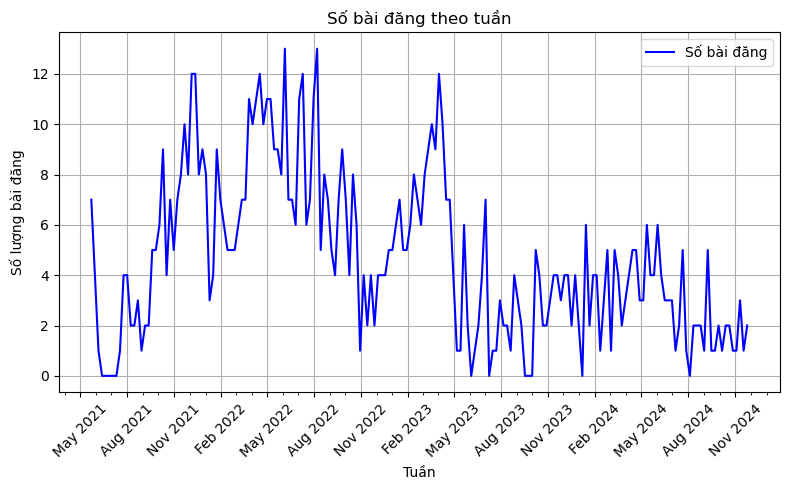

In [36]:
import matplotlib.dates as mdates
# Tạo cột Date từ year, month, day
read_df['Date'] = pd.to_datetime(read_df[['year', 'month', 'day']])

# Resample dữ liệu theo tuần
weekly_posts = read_df.resample('W', on='Date').size()
# Tính toán các chỉ số: trung bình, độ lệch chuẩn, trung vị, cao nhất và thấp nhất
mean_posts = weekly_posts.mean()  # Trung bình
std_posts = weekly_posts.std()    # Độ lệch chuẩn
median_posts = weekly_posts.median()  # Trung vị
max_posts = weekly_posts.max()  # Số bài đăng tuần cao nhất
min_posts = weekly_posts.min()  # Số bài đăng tuần thấp nhất

# In ra các giá trị tính toán
print(f"Trung bình số bài đăng theo tuần: {mean_posts:.2f}")
print(f"Độ lệch chuẩn của số bài đăng theo tuần: {std_posts:.2f}")
print(f"Trung vị số bài đăng theo tuần: {median_posts:.2f}")
print(f"Số bài đăng tuần cao nhất: {max_posts}")
print(f"Số bài đăng tuần thấp nhất: {min_posts}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(weekly_posts.index, weekly_posts.values, label='Số bài đăng', color='blue')
plt.title('Số bài đăng theo tuần')
plt.xlabel('Tuần')
plt.ylabel('Số lượng bài đăng')
plt.grid(True)
plt.legend()

# Định dạng trục thời gian: hiển thị theo tháng và năm
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Hiện mỗi 3 tháng
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Nhãn phụ mỗi tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Tháng + năm
plt.xticks(rotation=45)  # Xoay nhãn trục x

plt.tight_layout()
plt.show()


- Trung bình số bài đăng theo tuần: 4.69
- Xu hướng tổng thể cho thấy số lượng bài đăng theo tuần có xu hướng cao điểm vào năm 2022 và năm 2023.
- Sau giai đoạn này, tần suất đăng bài có xu hướng giảm dần.

Trung bình số bài đăng theo tháng: 20.07
Độ lệch chuẩn của số bài đăng theo tháng: 12.53
Trung vị số bài đăng theo tháng: 16.00
Số bài đăng tháng cao nhất: 46
Số bài đăng tháng thấp nhất: 0


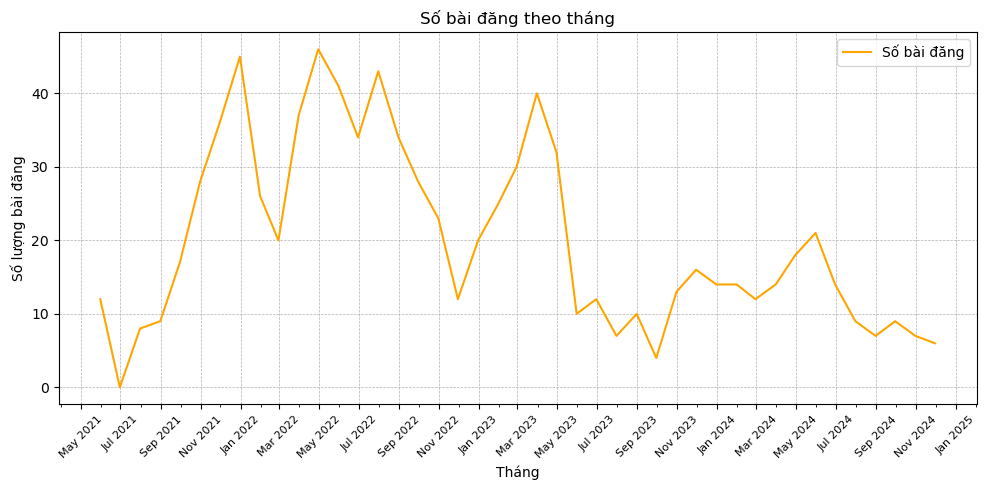

In [37]:
# Tạo cột Date từ year, month, day
read_df['Date'] = pd.to_datetime(read_df[['year', 'month', 'day']])

# Resample dữ liệu theo tháng
monthly_posts = read_df.resample('ME', on='Date').size()
# Tính toán các chỉ số: trung bình, độ lệch chuẩn, trung vị, cao nhất và thấp nhất
mean_posts = monthly_posts.mean()  # Trung bình
std_posts = monthly_posts.std()    # Độ lệch chuẩn
median_posts = monthly_posts.median()  # Trung vị
max_posts = monthly_posts.max()  # Số bài đăng tuần cao nhất
min_posts = monthly_posts.min()  # Số bài đăng tuần thấp nhất

# In ra các giá trị tính toán
print(f"Trung bình số bài đăng theo tháng: {mean_posts:.2f}")
print(f"Độ lệch chuẩn của số bài đăng theo tháng: {std_posts:.2f}")
print(f"Trung vị số bài đăng theo tháng: {median_posts:.2f}")
print(f"Số bài đăng tháng cao nhất: {max_posts}")
print(f"Số bài đăng tháng thấp nhất: {min_posts}")
# Vẽ biểu đồ
plt.figure(figsize=(10, 5))  # Giữ nguyên kích thước biểu đồ
plt.plot(monthly_posts.index, monthly_posts.values, label='Số bài đăng', color='orange')
plt.title('Số bài đăng theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Số lượng bài đăng')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

# Định dạng trục thời gian
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Hiện mỗi 2 tháng
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Nhãn phụ mỗi tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Tháng + năm
plt.xticks(rotation=45, fontsize=8)  # Thu nhỏ chữ hiển thị thời gian

plt.tight_layout()  # Đảm bảo không chồng chéo các thành phần
plt.show()

- Giai đoạn từ giữa năm 2022 đến đầu năm 2023 là thời điểm hoạt động mạnh nhất, với số lượng bài đăng cao, đạt đỉnh trên 40 bài/tháng.
- Sau đỉnh cao này, hoạt động giảm mạnh từ giữa năm 2023, duy trì ở mức thấp hơn 10 bài/tháng.

Số bài đăng từng năm:
Date
2021-12-31    155
2022-12-31    364
2023-12-31    213
2024-12-31    131
Freq: YE-DEC, dtype: int64
Trung bình số bài đăng theo năm: 215.75
Độ lệch chuẩn của số bài đăng theo năm: 104.66
Trung vị số bài đăng theo năm: 184.00
Số bài đăng năm cao nhất: 364
Số bài đăng năm thấp nhất: 131


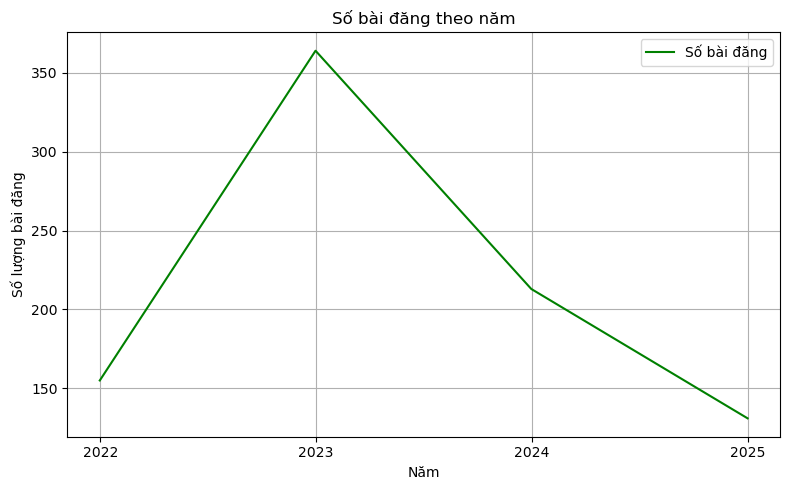

In [38]:
# Tạo cột Date từ year, month, day
read_df['Date'] = pd.to_datetime(read_df[['year', 'month', 'day']])

# Resample dữ liệu theo năm
yearly_posts = read_df.resample('YE', on='Date').size()
# Tính toán các chỉ số: trung bình, độ lệch chuẩn, trung vị, cao nhất và thấp nhất theo năm
mean_posts = yearly_posts.mean()  # Trung bình
std_posts = yearly_posts.std()    # Độ lệch chuẩn
median_posts = yearly_posts.median()  # Trung vị
max_posts = yearly_posts.max()  # Số bài đăng năm cao nhất
min_posts = yearly_posts.min()  # Số bài đăng năm thấp nhất

# In ra các giá trị tính toán
print("Số bài đăng từng năm:")
print(yearly_posts)
print(f"Trung bình số bài đăng theo năm: {mean_posts:.2f}")
print(f"Độ lệch chuẩn của số bài đăng theo năm: {std_posts:.2f}")
print(f"Trung vị số bài đăng theo năm: {median_posts:.2f}")
print(f"Số bài đăng năm cao nhất: {max_posts}")
print(f"Số bài đăng năm thấp nhất: {min_posts}")
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(yearly_posts.index, yearly_posts.values, label='Số bài đăng', color='green')
plt.title('Số bài đăng theo năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng bài đăng')
plt.grid(True)
plt.legend()

# Định dạng thời gian: từng năm một
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


- Dựa vào đồ thị, chúng ta có thể thấy được:
    + Số lượng bài đăng có xu hướng tăng lên từ năm 2022 đến năm 2023, đạt đỉnh ở khoảng 350 bài.
    + Sau năm 2023, số lượng bài đăng bắt đầu giảm dần.
- Năm 2022:
    + Đặc điểm: Số lượng bài đăng tương đối thấp(155 bài/1 năm).
    + Ý nghĩa: Đây có thể là giai đoạn khởi đầu của tài khoản, khi người dùng mới làm quen với nền tảng hoặc thử nghiệm nội dung. Hoạt động ít ỏi cũng có thể do chiến lược ban đầu chưa rõ ràng.
- Năm 2023:
    + Đặc điểm: Đây là năm bùng nổ với số lượng bài đăng cao nhất, phản ánh sự gia tăng mạnh mẽ về nội dung(364 bài/1 năm).
    + Ý nghĩa: Có khả năng tài khoản đã tập trung đẩy mạnh chiến lược nội dung, tập trung xây dựng kênh có quy mô, cải thiện chất lượng video hoặc đạt được các cột mốc quan trọng (ví dụ: tăng lượng người theo dõi, tương tác).
- Năm 2024, 2025:
    + Đặc điểm: Số lượng bài đăng giảm đáng kể, cho thấy tài khoản không còn duy trì mức độ hoạt động như trước.
    + Ý nghĩa: Sự suy giảm này có thể xuất phát từ nhiều nguyên nhân, chẳng hạn:
          Người sáng tạo nội dung mất động lực.
          Giảm tương tác từ người xem, dẫn đến giảm số lượng bài đăng.
          Hoặc là do kênh đã đi vào thời kì ổn định, nên đăng số lượng bài đăng vừa đù để duy trì.

### 1.2 Khung giờ đăng bài trong ngày 

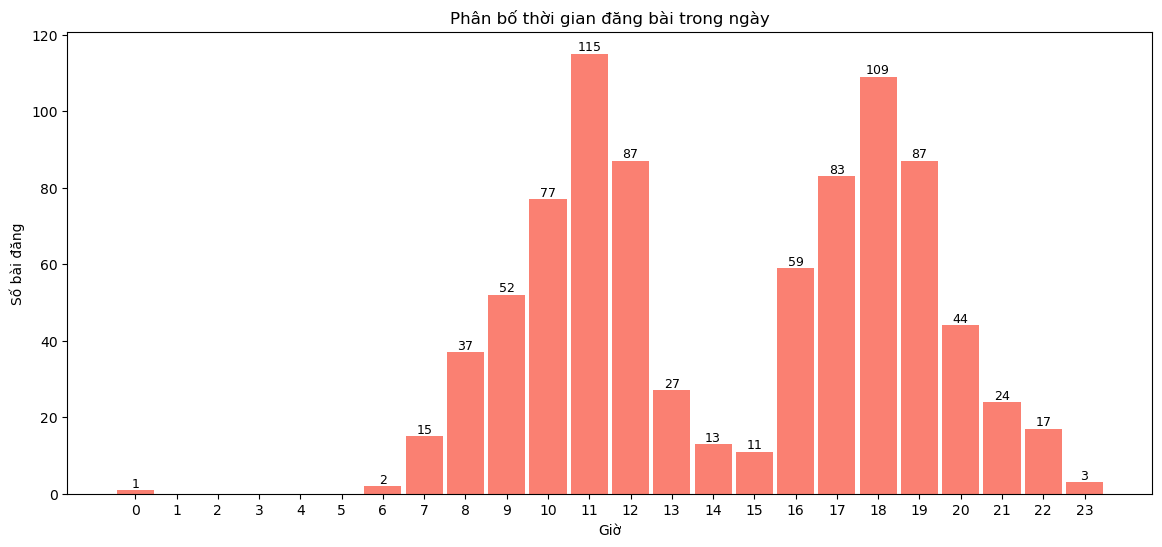

In [39]:
fig, time = plt.subplots(figsize=(14, 6))
time.hist(read_df['hour'], bins=np.arange(0, 25, 1), color='salmon', rwidth=0.9,align='left')
time.set_xticks(range(0, 24))
time.set_xlabel('Giờ')
time.set_ylabel('Số bài đăng')
time.set_title('Phân bố thời gian đăng bài trong ngày')
for patch in time.patches:
    height = patch.get_height()
    if height > 0:
        time.text(patch.get_x() + patch.get_width() / 2,
                  height,
                  int(height),
                  ha='center', va='bottom', fontsize=9, color='black')
plt.show()


Từ dữ biểu đồ trên, ta dễ dàng có thể thấy 2 khung giờ đăng bài phổ biến nhất là từ 10 - 12h và từ 17 - 19h. Đây là các thời gian nghỉ trưa, nghỉ buổi chiều của đa số mọi người, khung giờ dễ lấy được tương tác là thời gian mọi người rảnh để có thể vào xem.

### 1.3 Thời lượng video 

In [40]:
# Trung bình độ dài video:
Median = read_df["videoMeta/duration"].median()
Mean = read_df["videoMeta/duration"].mean()
print("Trung bình thời lượng video là: " + str(float(Median)))
print("Trung vị độ dài video là: "+ str(float(Mean)))

Trung bình thời lượng video là: 79.0
Trung vị độ dài video là: 112.70683661645423


In [41]:
#Độ dài tối thiểu, tối đa:
Max_video = read_df['videoMeta/duration'].max()
Min_video = read_df['videoMeta/duration'].min()

Standard_deviation = read_df['videoMeta/duration'].std()
print("Độ dài video tối thiểu là: " + str(float(Min_video)))
print("Độ dài video tối đa là: " + str(float(Max_video)))
print("Độ lệch chuẩn: " + str(float(Standard_deviation)))

Độ dài video tối thiểu là: 7.0
Độ dài video tối đa là: 597.0
Độ lệch chuẩn: 96.07552634751077


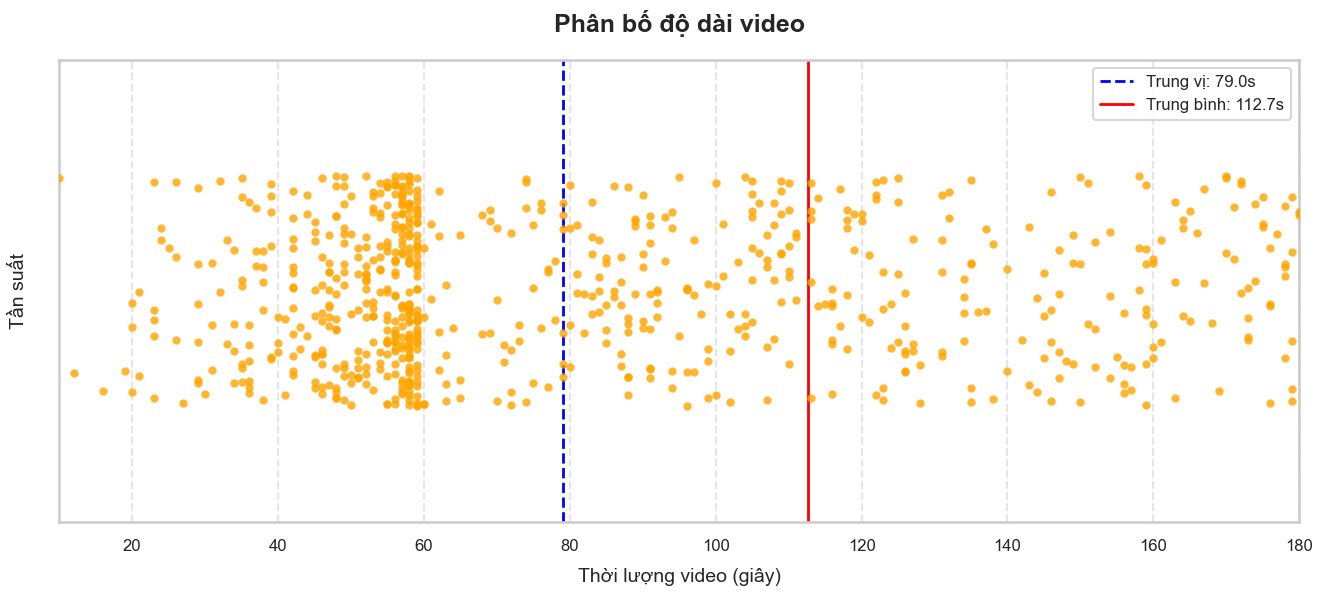

In [42]:
plt.figure(figsize=(16, 6))  
sns.set_theme(style="whitegrid", context="talk")

sns.stripplot(
    data=read_df, 
    x="videoMeta/duration", 
    color="orange", 
    jitter=0.25,         
    size=6,              
    alpha=0.8            
)


plt.axvline(Median, color='blue', linestyle='--', label=f'Trung vị: {Median:.1f}s', linewidth=2)
plt.axvline(Mean, color='red', linestyle='-', label=f'Trung bình: {Mean:.1f}s', linewidth=2)

plt.title("Phân bố độ dài video", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Thời lượng video (giây)", fontsize=14, labelpad=10)
plt.ylabel("Tần suất", fontsize=14, labelpad=10)

plt.xticks(fontsize=12, rotation=0)  
plt.yticks(fontsize=12)
plt.xlim(10, 180)  

# Chú thích
plt.legend(fontsize=12, loc='upper right')

# Thêm lưới nhẹ
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


Ta có thể thấy rằng thời lượng video được phân bố khá đều từ khoảng 10 giây đến 180 giây. Trong đó với trung vị khoảng 79.0s và giá trị tủng bình khoảng 112.7s 
=> Đây là đặc trưng thời lượng video của ứng dụng giải trí nhanh giúp người xem dễ dàng tiếp thu kiến thức qua các video ngắn, dễ hiểu, dễ nhớ

Thêm vào đó, dựa vào biểu đồ, xu hướng up video của kênh thường tập trung nhiều vào các video dài 40s-60s, đây là khoảng thời gian lý tưởng để tối ưu hóa nội dung cho người xem khi xem một video về lịch sử



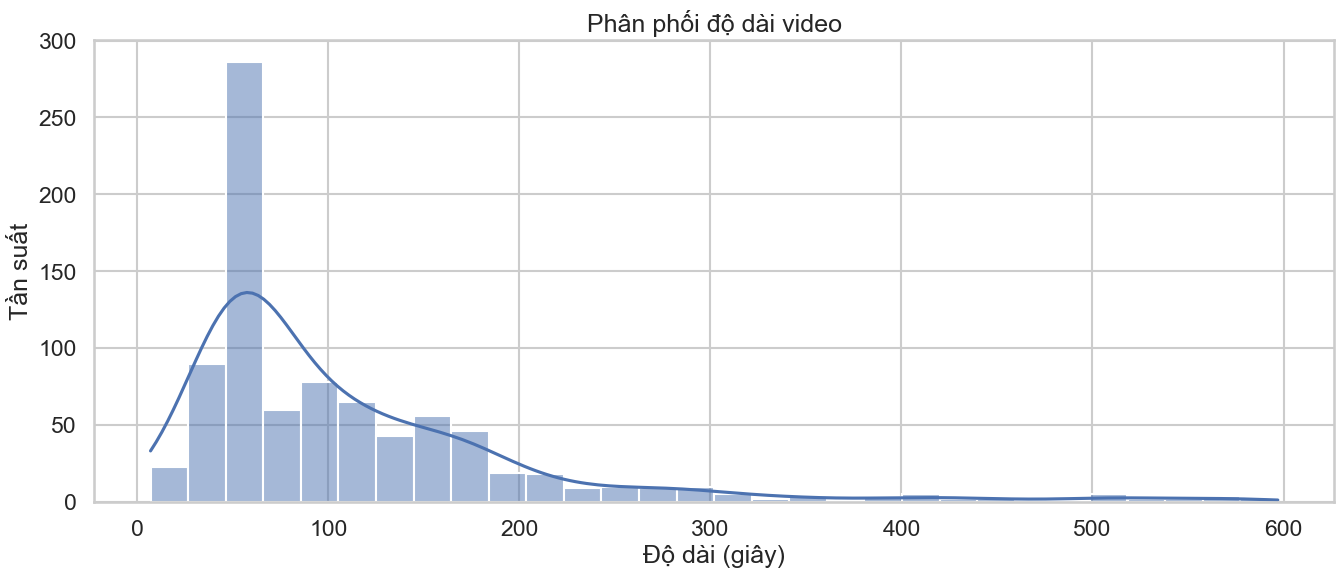

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 6))  
sns.set_theme(style="whitegrid", context="talk")
# Biểu đồ phân phối
sns.histplot(read_df["videoMeta/duration"], bins=30, kde=True)
plt.title('Phân phối độ dài video')
plt.xlabel('Độ dài (giây)')
plt.ylabel('Tần suất')
plt.show()

Dựa vào biểu đồ ta có thể thấy rằng: Khi độ dài video tăng (lớn hơn 100 giây), tần suất giảm dần, cho thấy ít video có thời lượng dài hơn. Bên cạnh đó, phân phối có xu hướng lệch phải, đặc trưng bởi số lượng lớn các video ngắn và giảm dần khi độ dài tăng lên.

**Tổng quan thời lượng video qua các ngày**

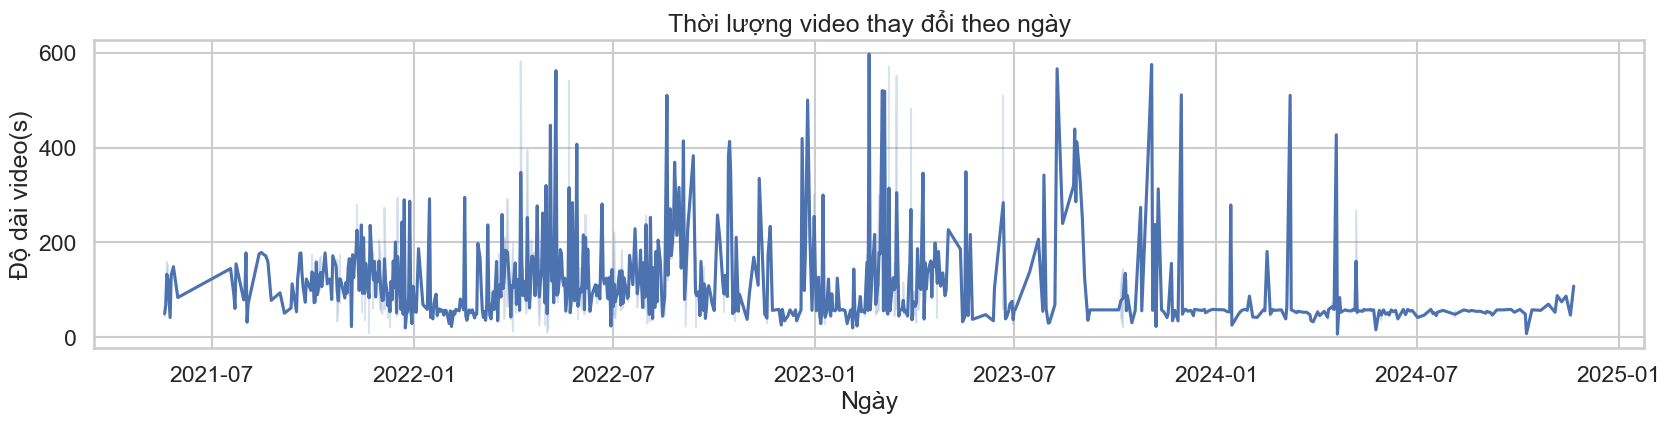

In [44]:
plt.figure(figsize=(20,4))
sns.lineplot(data = read_df, x = read_df['date'], y= read_df['videoMeta/duration'])
plt.title('Thời lượng video thay đổi theo ngày')
plt.xlabel('Ngày')
plt.ylabel('Độ dài video(s)')
plt.show()

Từ năm 2022-2023, thời lượng của video khá lớn và giữ vững giá trị tủng bình, tuy nhiên đến năm 2024, tần suất dài của video giảm mạnh dù vẫn đạt các cột mốc lượng trung bình của video tăng mạnh

**Phân tích độ dài video theo thời gian**

**Theo ngày**

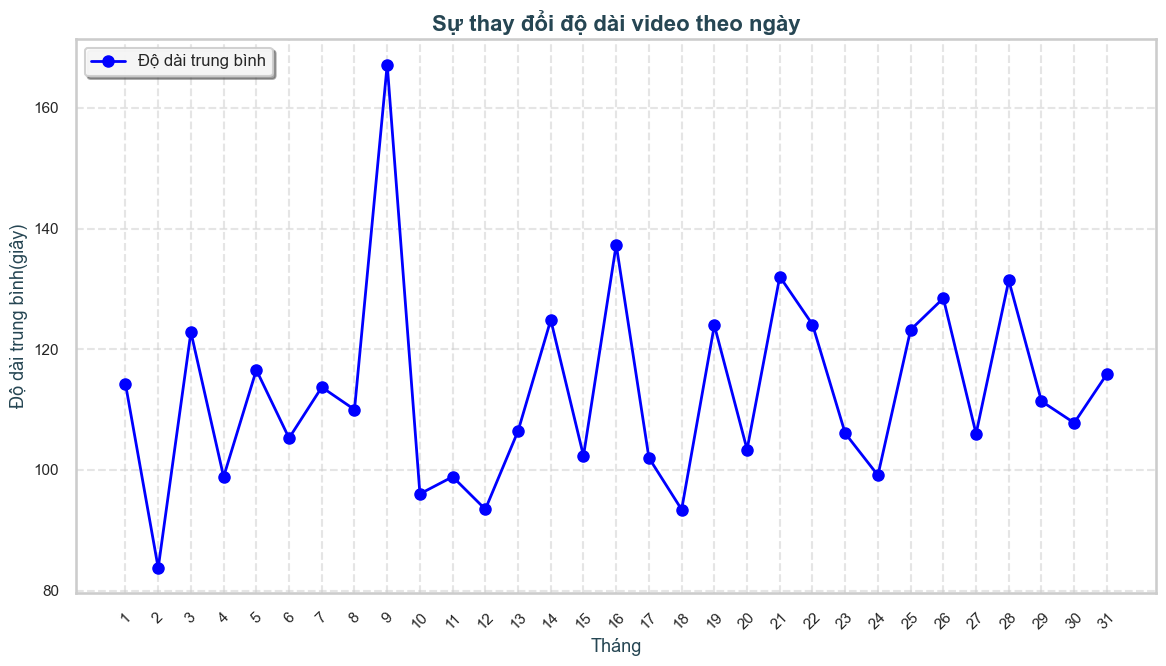

In [45]:
avgl_month = (read_df.groupby('day')['videoMeta/duration'].mean().reset_index(name='avgl_day'))

sns.set_style('whitegrid')  
palette = sns.color_palette('coolwarm', n_colors=len(avgl_month))  

plt.figure(figsize=(12, 7))  
plt.plot(
    avgl_month['day'].astype(str),  
    avgl_month['avgl_day'],  
    marker='o',  
    linestyle='-',  
    linewidth=2,  
    markersize=8,  
    color='blue',  
    label='Độ dài trung bình'
)

plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.title('Sự thay đổi độ dài video theo ngày', fontsize=16, fontweight='bold', color='#264653')
plt.xlabel('Tháng', fontsize=13, color='#264653')
plt.ylabel('Độ dài trung bình(giây)', fontsize=13, color='#264653')
plt.grid(True, linestyle='--', alpha=0.5)  
plt.legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.9, shadow=True)
plt.tight_layout()
plt.show()

Dựa vào biểu đồ, độ dài trung bình của video có nhiều biến động lên xuống, trong đó tăng mạnh và đạt đỉnh vào ngày 9 hàng tháng

**Theo tháng**

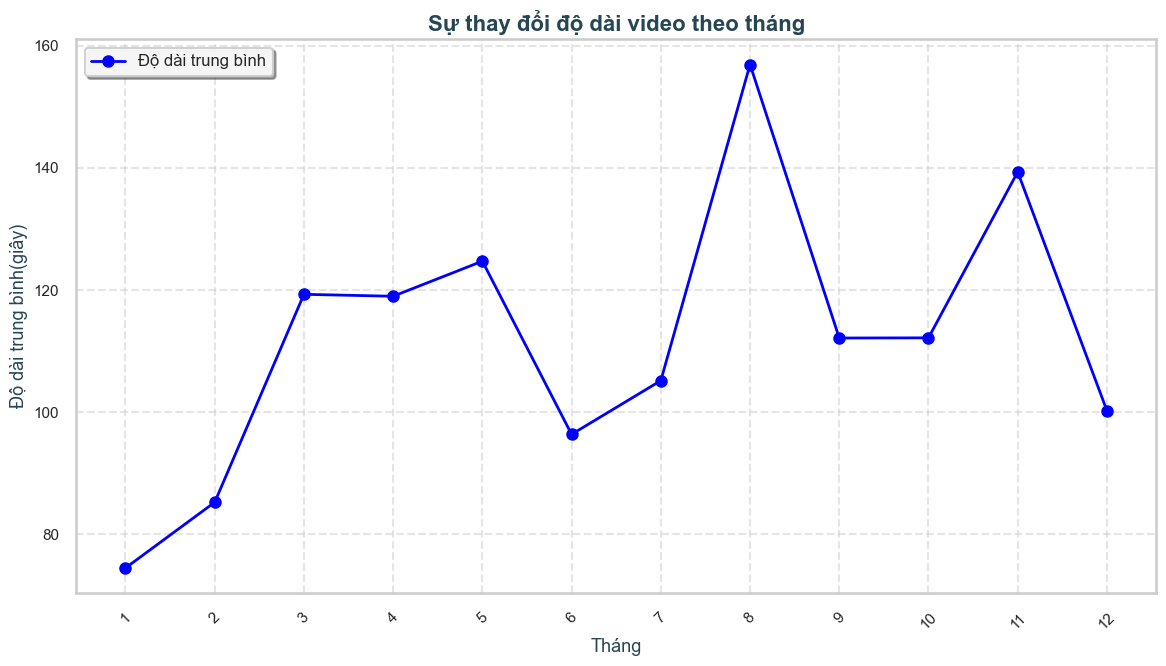

In [46]:
avgl_month = (read_df.groupby('month')['videoMeta/duration'].mean().reset_index(name='avgl_month'))

sns.set_style('whitegrid')  
palette = sns.color_palette('coolwarm', n_colors=len(avgl_month))  

plt.figure(figsize=(12, 7))  
plt.plot(
    avgl_month['month'].astype(str),  
    avgl_month['avgl_month'],  
    marker='o',  
    linestyle='-',  
    linewidth=2,  
    markersize=8,  
    color='blue',  
    label='Độ dài trung bình'
)

plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.title('Sự thay đổi độ dài video theo tháng', fontsize=16, fontweight='bold', color='#264653')
plt.xlabel('Tháng', fontsize=13, color='#264653')
plt.ylabel('Độ dài trung bình(giây)', fontsize=13, color='#264653')
plt.grid(True, linestyle='--', alpha=0.5)  
plt.legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.9, shadow=True)
plt.tight_layout()
plt.show()

Dựa vào biểu đồ, thời lượng video tăng nhanh đột biến vào khoảng tháng 4, tháng 8 và tháng 11, đây là thời điểm trong năm có các sự kiện lịch sử lớn của dân tộc như Giải phóng miền Nam, Thống nhất đất nước (30/4), Cách Mạng tháng Tám thành công,...

Trong các tháng như tháng 6 và tháng 12, kênh tập trung vào nội dung ngắn gọn, phù hợp hơn với thị hiếu thời điểm đó.

**Theo năm**

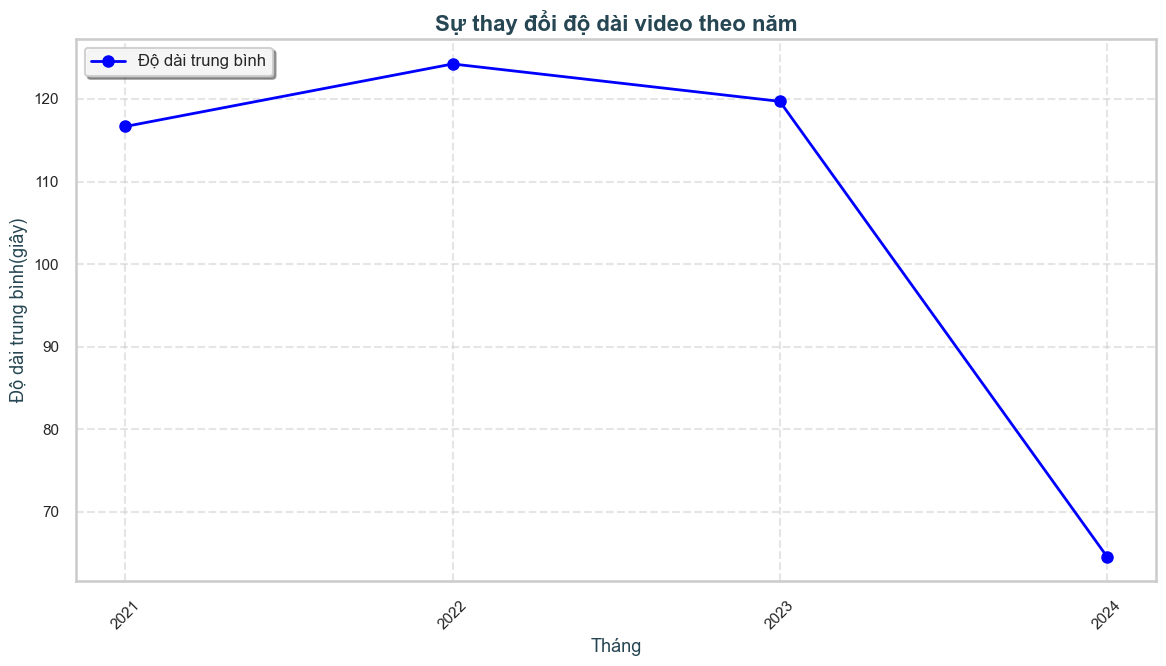

In [47]:
avgl_month = (read_df.groupby('year')['videoMeta/duration'].mean().reset_index(name='avgl_year'))

sns.set_style('whitegrid')  
palette = sns.color_palette('coolwarm', n_colors=len(avgl_month))  

plt.figure(figsize=(12, 7))  
plt.plot(
    avgl_month['year'].astype(str),  
    avgl_month['avgl_year'],  
    marker='o',  
    linestyle='-',  
    linewidth=2,  
    markersize=8,  
    color='blue',  
    label='Độ dài trung bình'
)

plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.title('Sự thay đổi độ dài video theo năm', fontsize=16, fontweight='bold', color='#264653')
plt.xlabel('Tháng', fontsize=13, color='#264653')
plt.ylabel('Độ dài trung bình(giây)', fontsize=13, color='#264653')
plt.grid(True, linestyle='--', alpha=0.5)  
plt.legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.9, shadow=True)
plt.tight_layout()
plt.show()

Nhìn chung, trung bình độ dài video của kênh tăng và đạt đỉnh tại năm 2022, sau đó giảm nhẹ vào năm 2023 và giảm mạnh vào năm 2024

**Dạng Barplot**

In [48]:
video_duration_by_week = pd.DataFrame()
video_duration_by_week['Week'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%W')
video_duration_by_week = video_duration_by_week.sort_values('Week')
video_duration_by_week = video_duration_by_week.groupby('Week').size().reset_index(name='Video Duration')

video_duration_by_month = pd.DataFrame()
video_duration_by_month['Month'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%m')
video_duration_by_month = video_duration_by_month.sort_values('Month')
video_duration_by_month = video_duration_by_month.groupby('Month').size().reset_index(name='Video Duration')

video_duration_by_year = pd.DataFrame()
video_duration_by_year['Year'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y')
video_duration_by_year = video_duration_by_year.sort_values('Year')
video_duration_by_year = video_duration_by_year.groupby('Year').size().reset_index(name='Video Duration')



Text(0.5, 1.0, 'Video Duration by Year')

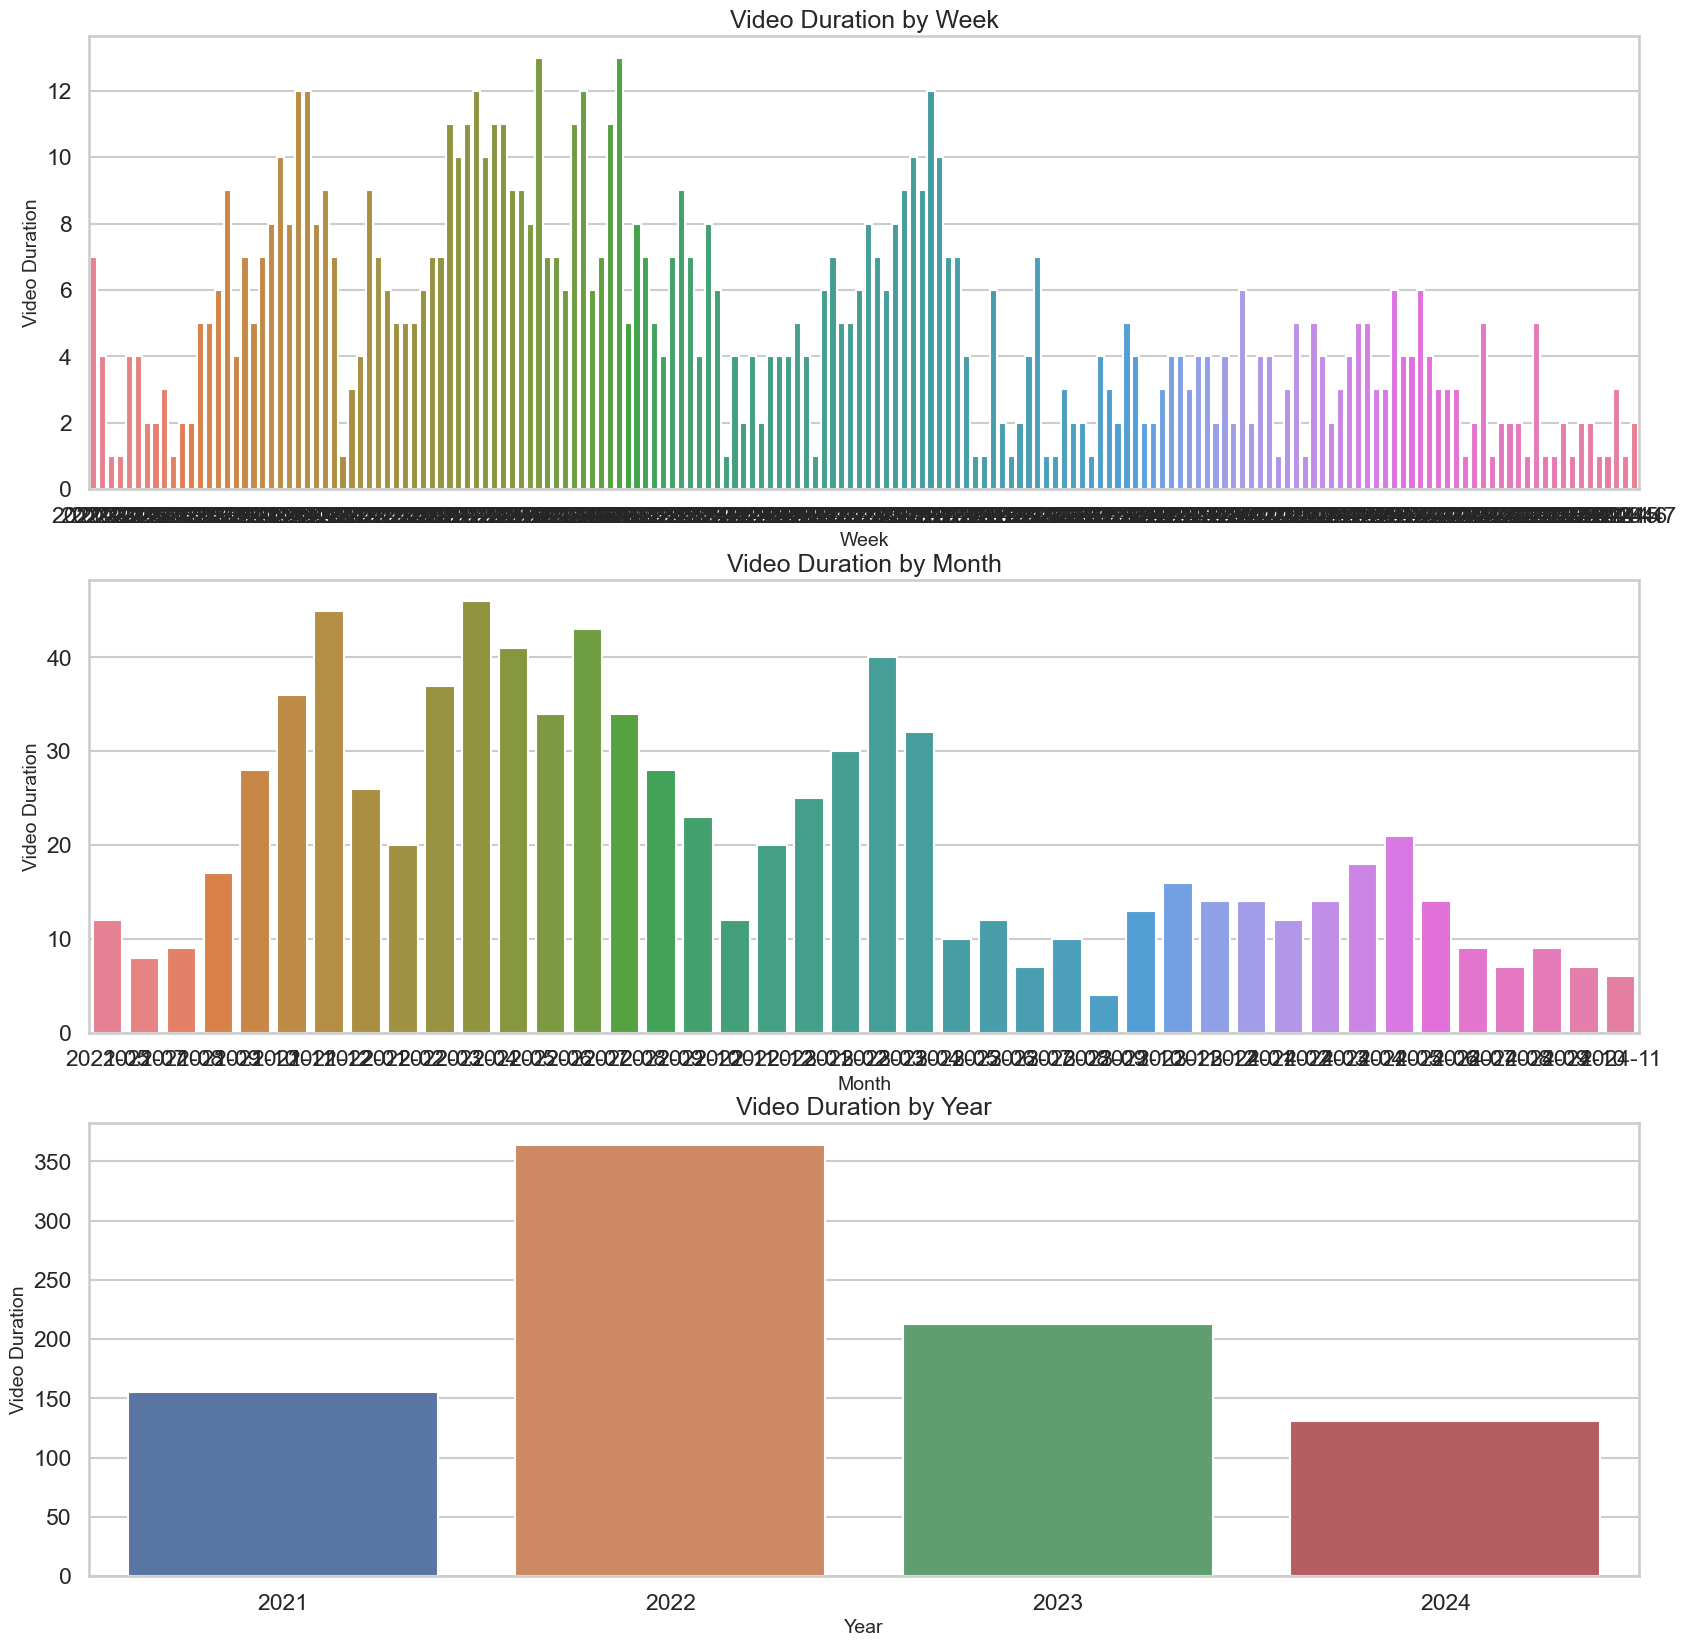

In [49]:
fig, axes = plt.subplots(3,1,figsize = (20,20))
sns.barplot(data= video_duration_by_week, x = 'Week', y='Video Duration', ax=axes[0], hue = 'Week')
axes[0].set_xlabel('Week', fontsize = 14)
axes[0].set_ylabel('Video Duration', fontsize = 14)
axes[0].set_title('Video Duration by Week', fontsize =18)

sns.barplot(data= video_duration_by_month, x = 'Month', y='Video Duration', ax=axes[1], hue = 'Month')
axes[1].set_xlabel('Month', fontsize = 14)
axes[1].set_ylabel('Video Duration', fontsize = 14)
axes[1].set_title('Video Duration by Month', fontsize =18)

sns.barplot(data= video_duration_by_year, x ='Year', y='Video Duration', ax=axes[2], hue = 'Year')
axes[2].set_xlabel('Year', fontsize = 14)
axes[2].set_ylabel('Video Duration', fontsize = 14)
axes[2].set_title('Video Duration by Year', fontsize =18)


Ta có thể thấy rằng thời lượng video có xu hướng tăng mạnh vào năm 2022 và giảm dần về sau nhưng vẫn duy trì khá ổn định

In [50]:
video_duration_contrb_by_year = pd.DataFrame()
video_duration_contrb_by_year['Month'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%M')
video_duration_contrb_by_year['Year'] = read_df['year']
video_duration_contrb_by_year['Date'] = read_df['date']
video_duration_contrb_by_year['Video Duration'] = read_df['videoMeta/duration']



In [51]:
video_duration_contrb_by_year

,Month,Year,Date,Video Duration
0,2024-04,2024,2024-11-21,108
1,2024-56,2024,2024-11-18,47
2,2024-25,2024,2024-11-14,87
3,2024-24,2024,2024-11-10,75
4,2024-46,2024,2024-11-06,88
...,...,...,...,...
858,2021-49,2021,2021-05-21,107
859,2021-15,2021,2021-05-21,159
860,2021-43,2021,2021-05-20,68
861,2021-58,2021,2021-05-19,58


Text(0, 0.5, 'Video Duration')

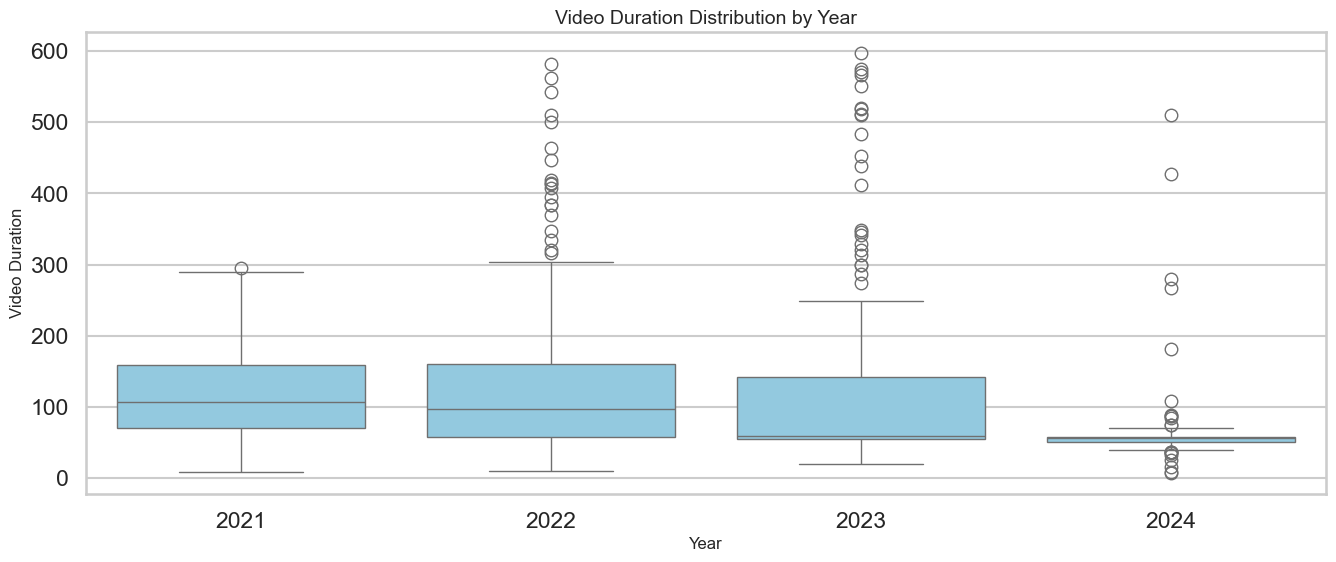

In [52]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='Year', y='Video Duration', data=video_duration_contrb_by_year, color='skyblue')

plt.title('Video Duration Distribution by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Video Duration', fontsize=12)


Dựa vào biểu đồ, ta thấy rằng xu hướng thời lượng video:

Thời lượng video trung bình tăng cao trong 2022 và 2023, sau đó giảm đáng kể trong 2024.
Phân tán dữ liệu (IQR) lớn nhất trong 2022 và 2023, cho thấy sự đa dạng về thời lượng video trong giai đoạn này.
2024 có thời lượng video giảm mạnh, với dữ liệu ít phân tán hơn.
Ngoại lệ (Outliers):

Số lượng outliers lớn nhất trong 2022 và 2023, có thể do một số video có thời lượng bất thường.
2021 và 2024 có ít outliers hơn, với giá trị thời lượng thấp hơn.



### 1.4 Phân bố độ dài caption của video

In [53]:
read_df['text_length'].dropna().head(200)

0      14
1      11
2      11
3      13
4       9
       ..
195     5
196     5
197     4
198     5
199     4
Name: text_length, Length: 200, dtype: int64

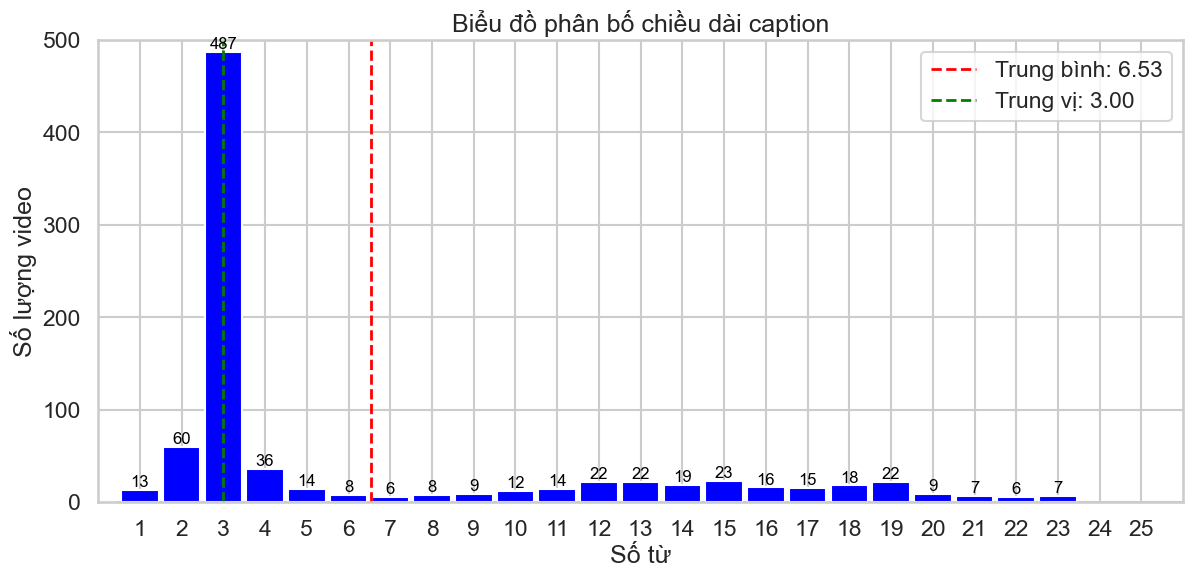

In [54]:

fig, text_length = plt.subplots(figsize=(14, 6))
text_length.hist(read_df['text_length'], bins=np.arange(0, 25, 1), color='blue', rwidth=0.9,align='left')
text_length.set_xlim(0,26)
text_length.set_ylim(0,500)
text_length.set_xticks(range(1,26,1))
text_length.set_xlabel('Số từ')
text_length.set_ylabel('Số lượng video')
text_length.set_title('Biểu đồ phân bố chiều dài caption')

for patch in text_length.patches:
    height = patch.get_height()
    if height > 0:
        text_length.text(patch.get_x() + patch.get_width() / 2,
                  height,
                  int(height),
                  ha='center', va='bottom', fontsize=12, color='black')
mean_value = read_df['text_length'].mean()
median_value = read_df['text_length'].median()
text_length.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Trung bình: {mean_value:.2f}')
text_length.axvline(median_value, color='green', linestyle='--', linewidth=2, label=f'Trung vị: {median_value:.2f}')
text_length.legend()
plt.show()

Chiều dài caption của các video hầu hết nằm trong khoảng 2 đến 4 kí tự với giá trị trung bình của độ dài là 6.53, giá trị trung vị là 3.00. Đây là giá trị phù hợp vì hầu hết các video tiktok cung cấp lượng lớn thông tin qua nội dung video, caption mang hàm lượng thông tin thấp, chủ yếu là chú thích và tóm tắt thêm cho nội dung video. Đây là xu hướng hiện tại của giới trẻ khi sẽ ưu tiên việc nghe nhiều hơn đọc.

## 2. Phân tích tương tác

### 2.1 Tổng quan về tương tác của tài khoản

#### 2.1.1 Lượng trung bình tương tác của kênh

In [55]:
print('Trung bình lượt thích là: ' + str(read_df['diggCount'].mean()))
print('Trung bình lượt bình luận là: ' + str(read_df['commentCount'].mean()))
print('Trung bình lượt lưu lại là: ' + str(read_df['collectCount'].mean()))
print('Trung bình lượt chia sẻ là: ' + str(read_df['shareCount'].mean()))
print('Trung bình lượt phát là: ' + str(read_df['playCount'].mean()))


Trung bình lượt thích là: 70468.66164542294
Trung bình lượt bình luận là: 1099.9617612977984
Trung bình lượt lưu lại là: 1763.3047508690613
Trung bình lượt chia sẻ là: 697.106604866744
Trung bình lượt phát là: 1054663.3835457705


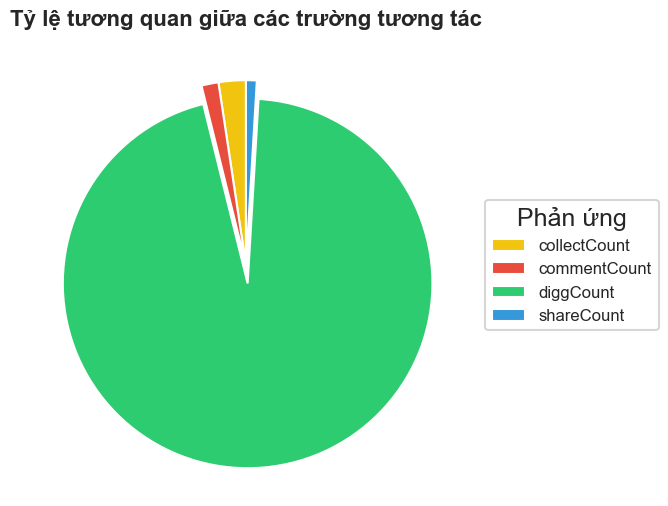

In [56]:
reaction_count = read_df[['collectCount', 'commentCount', 'diggCount', 'shareCount']].copy()

reactions = ['collectCount', 'commentCount', 'diggCount', 'shareCount']

read_df['ReactionCount'] = read_df['collectCount'] + read_df['commentCount'] + read_df['diggCount'] + read_df['shareCount']

reaction_sum = [read_df['collectCount'].sum(), read_df['commentCount'].sum(), read_df['diggCount'].sum(), read_df['shareCount'].sum() ]

mycolor = ['#f1c40f', '#e74c3c', '#2ecc71', '#3498db']  
plt.figure(figsize=(18, 6))
explode = (0, 0, 0.1, 0)  
plt.pie(reaction_sum, 
        colors=mycolor, 
        startangle=90, 
        explode=explode) 
plt.title('Tỷ lệ tương quan giữa các trường tương tác', fontsize=16, fontweight='bold')
plt.legend(reactions, 
           title="Phản ứng", 
           loc="center left", 
           bbox_to_anchor=(1, 0.5),  
           fontsize=12)



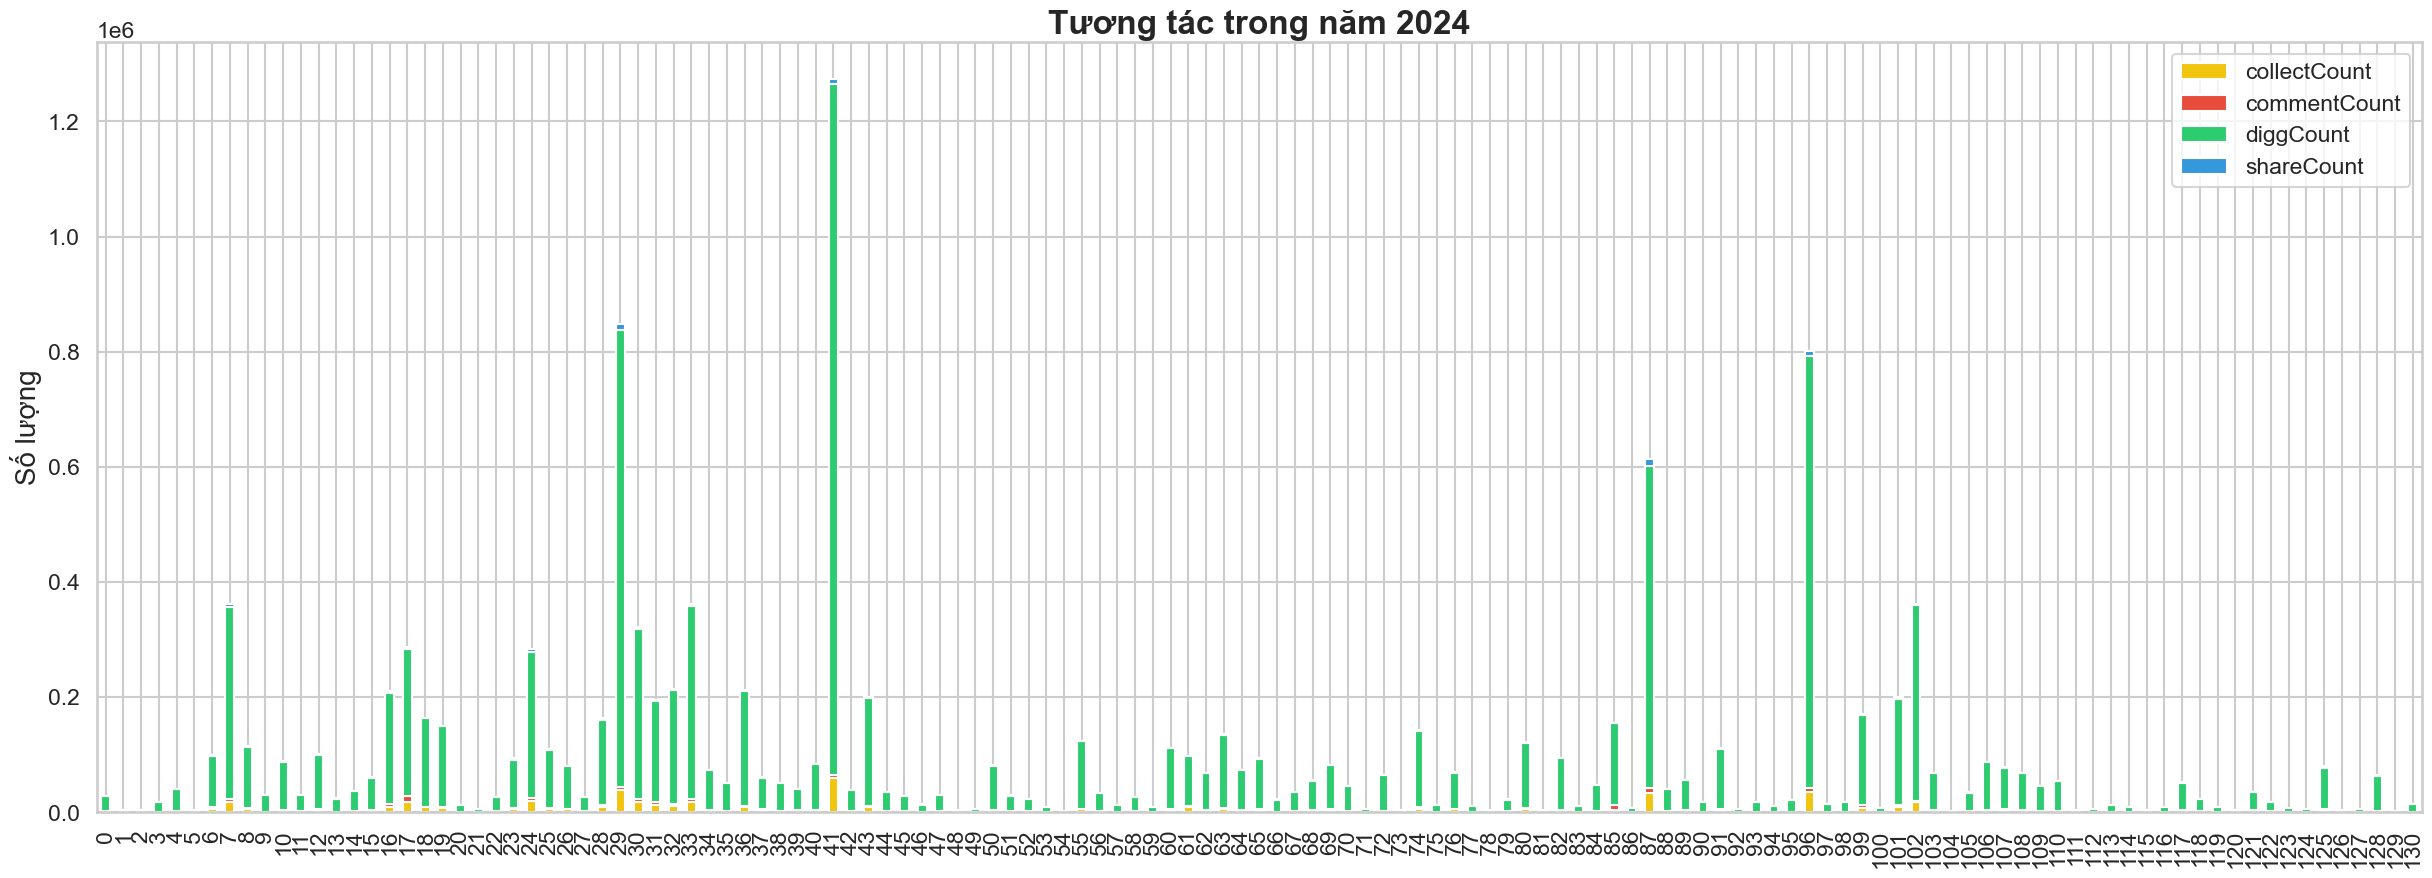

In [57]:
reaction_count_2024 = read_df[read_df['year'] == 2024][['collectCount', 'commentCount', 'diggCount', 'shareCount']]
reaction_count_2024.plot(kind='bar', stacked=True, figsize=(30, 10), color=['#f1c40f', '#e74c3c', '#2ecc71', '#3498db'])

plt.title('Tương tác trong năm 2024', fontsize=24, fontweight='bold')
plt.xlabel('', fontsize=20)
plt.ylabel('Số lượng', fontsize=20)

plt.show()


Lượt tương tác trong năm nhẩy vọt vào khoảng quý 2 sau đó giảm mạnh, duy trì , vọt lên vào cuối quý 3, đầu quý 4 trong năm, cho thấy xu hướng tương tác nhìn chung không có nhiều biến động nhưng giảm dần về cuối năm

### 2.2 Phân tích tỉ lệ tương tác, lấy ra top 10 bài có tỉ lệ tương tác cao nhất

In [58]:
rate_reaction = read_df.copy()
rate_reaction['ER'] = ((rate_reaction['diggCount'] + rate_reaction['commentCount'] + rate_reaction['shareCount']) / rate_reaction['playCount']) * 100

top_10_er = rate_reaction.nlargest(10, 'ER')


In [59]:
top_10_er['ind'] = np.arange(1, 11)
print(top_10_er[['diggCount', 'commentCount', 'shareCount', 'playCount', 'ER']])


     diggCount  commentCount  shareCount  playCount         ER
788      51500          1466         282     305900  17.406996
860      73700          1195         293     434800  17.292548
813      15300           333         146     102300  15.424242
620      59200           544         120     405300  14.770294
803     470800          6512        1952    3300000  14.523152
845     137200          6262        1030    1000000  14.449200
232      42000           476         418     301500  14.226866
792      23800           330          84     172400  14.045244
553      13300           263          70      97100  14.040165
819     123000          3006        1283     917300  13.876485


Có sự chênh lệch khá cao trong top 10 bài tương tác, thể hiện sự nhảy vọt tương tác của tài khoản

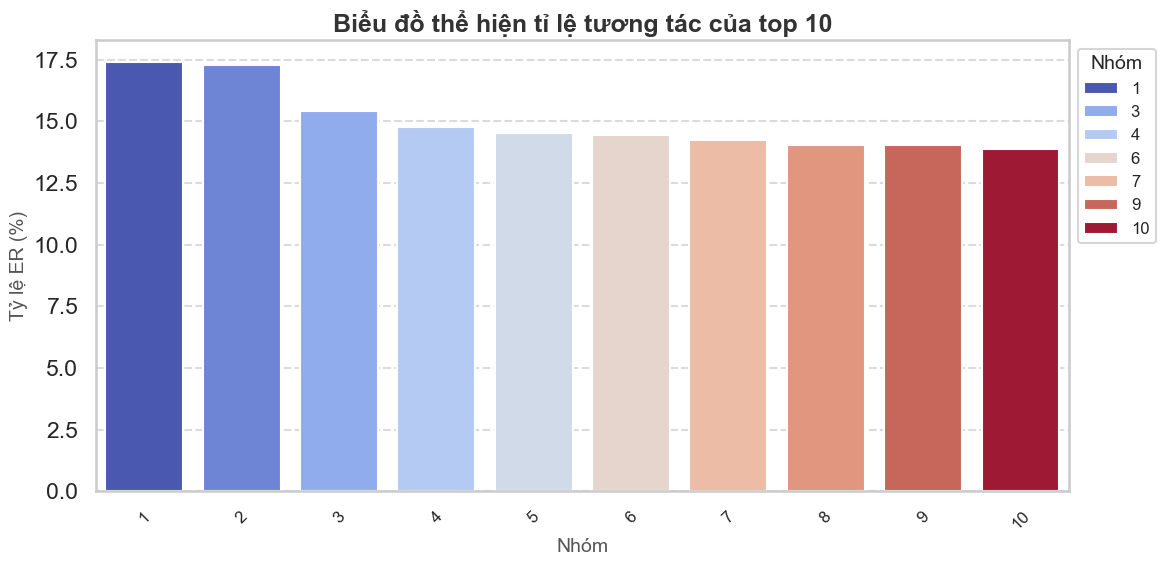

In [60]:

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_er, x='ind', y='ER', hue='ind', palette='coolwarm')
plt.title('Biểu đồ thể hiện tỉ lệ tương tác của top 10', fontsize=18, fontweight='bold', color='#333')
plt.xlabel('Nhóm', fontsize=14, color='#555')
plt.ylabel('Tỷ lệ ER (%)', fontsize=14, color='#555')
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Nhóm', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, title_fontsize=14, frameon=True)
plt.tight_layout()
plt.show()



### 2.3 So sánh tỉ lệ tương tác của các ngày trong tuần

In [96]:
reaction_by_week = read_df[['collectCount', 'commentCount', 'diggCount', 'shareCount', 'playCount', 'createTimeISO', 'hour']].copy()
reaction_by_week['rate of reaction'] = (reaction_by_week['diggCount'] + reaction_by_week['shareCount'] + reaction_by_week['commentCount'])/(reaction_by_week['playCount'])*100
reaction_by_week['day of week'] = reaction_by_week['createTimeISO'].dt.day_of_week

In [62]:

print('Độ lệch chuẩn là: ' + str(reaction_by_week['rate of reaction'].std()))
print('Phương sai: ' + str(reaction_by_week['rate of reaction'].var()))


Độ lệch chuẩn là: 2.47373249723896
Phương sai: 6.1193524678961


<Figure size 1500x600 with 0 Axes>

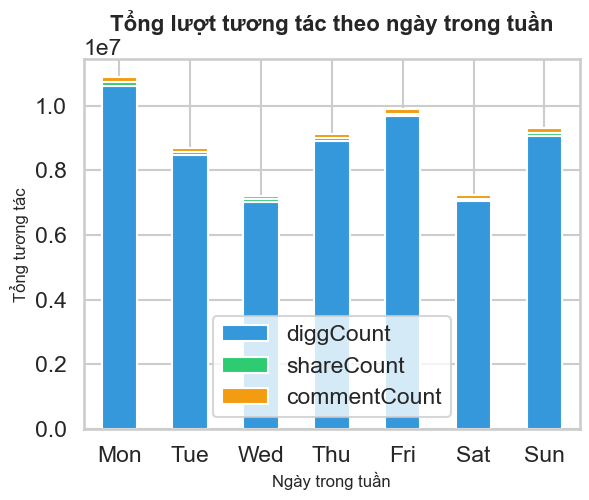

In [63]:
reaction_by_week_grouped = reaction_by_week.groupby('day of week')[['diggCount', 'shareCount', 'commentCount']].sum()
plt.figure(figsize=(15, 6))
reaction_by_week_grouped.plot(kind='bar', stacked=True, color=['#3498db', '#2ecc71', '#f39c12'])
plt.title('Tổng lượt tương tác theo ngày trong tuần', fontsize=16, fontweight='bold')
plt.xlabel('Ngày trong tuần', fontsize=12)
plt.ylabel('Tổng tương tác', fontsize=12)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()


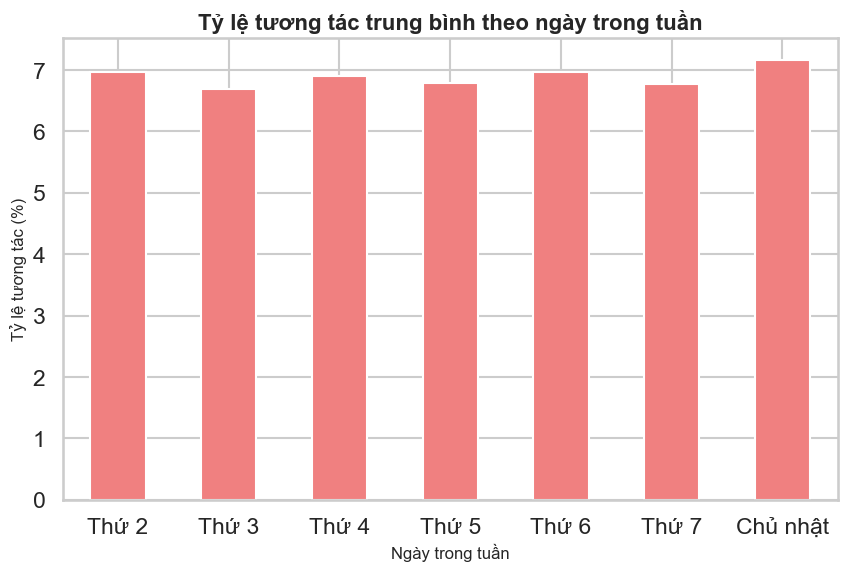

In [64]:
average_rate_by_week = reaction_by_week.groupby('day of week')['rate of reaction'].mean()

plt.figure(figsize=(10, 6)), average_rate_by_week.plot(kind='bar', color='#f08080')
plt.title('Tỷ lệ tương tác trung bình theo ngày trong tuần', fontsize=16, fontweight='bold')
plt.xlabel('Ngày trong tuần', fontsize=12)
plt.ylabel('Tỷ lệ tương tác (%)', fontsize=12)
plt.xticks(ticks=range(7), labels=['Thứ 2', 'Thứ 3', 'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ nhật'], rotation=0)
plt.show()


Tỉ lệ tương tác trong tuần rất ổn định, xấp xỉ 7%. Trong đó cao nhất là vào Chủ nhật, với lượt tương tác xấp xỉ 7,1%
Qua đó dễ dàng nhận định lượng tương tác vào cuối tuần hoặc đầu tuần thường có xu hướng cao hơn các ngày trong tuần


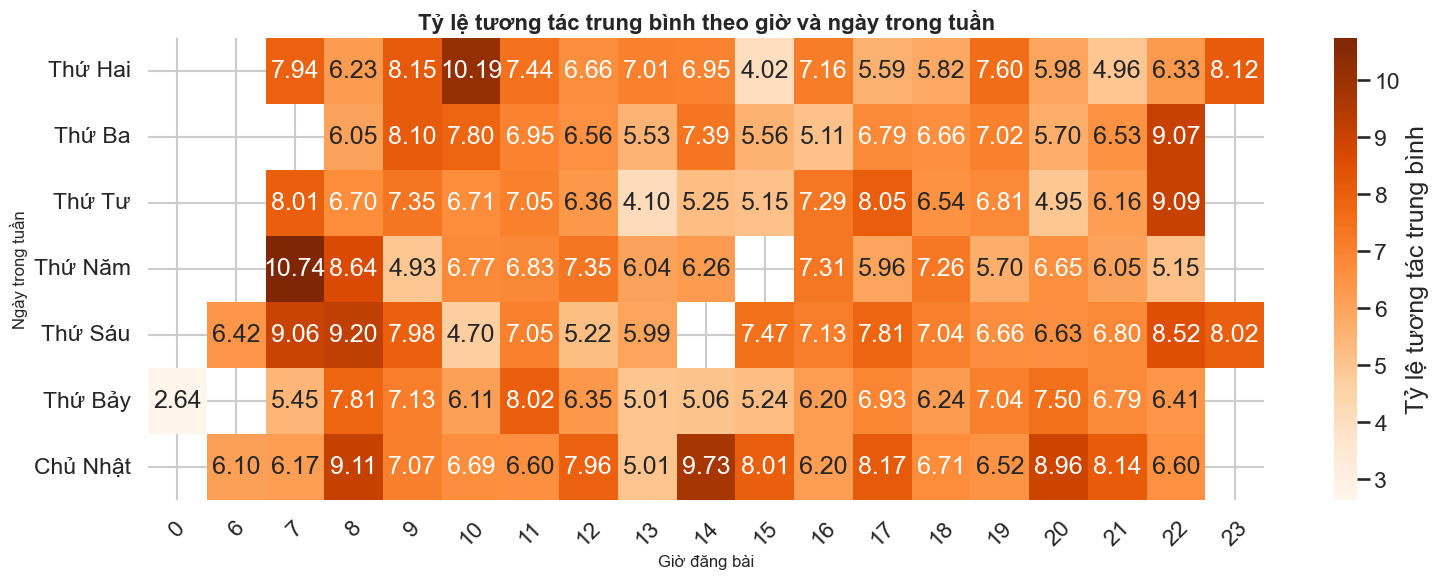

In [102]:
heatmap_data = reaction_by_week.groupby(['day of week', 'hour'])['rate of reaction'].mean().unstack()
new_labels = ["Thứ Hai", "Thứ Ba", "Thứ Tư", "Thứ Năm", "Thứ Sáu", "Thứ Bảy", "Chủ Nhật"]
heatmap_data.index = new_labels
plt.figure(figsize=(18, 6))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".2f", 
    cmap="Oranges" ,
    cbar_kws={'label': 'Tỷ lệ tương tác trung bình'}
)
plt.title("Tỷ lệ tương tác trung bình theo giờ và ngày trong tuần", fontsize=16, fontweight='bold')
plt.xlabel("Giờ đăng bài", fontsize=12)
plt.ylabel("Ngày trong tuần", fontsize=12)
plt.xticks(rotation=45)
plt.show()

### 2.4 Phân tích tương tác của tài khoản qua comment

In [65]:

comment_data = read_df.copy()
print('Tổng số lượt comment là: ' + str(comment_data['commentCount'].sum()))
print('Trung bình lượt commnet là: ' + str(comment_data['commentCount'].mean()))
print('Trung vị số comment là: ' + str(comment_data['commentCount'].median()))


Tổng số lượt comment là: 949267
Trung bình lượt commnet là: 1099.9617612977984
Trung vị số comment là: 369.0


In [66]:
#Video có lượt comment cao nhất:

cmt_max_comment = comment_data['commentCount'].max()
print_max = comment_data[comment_data['commentCount'] == cmt_max_comment]
print_max


,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
643,6391,31000,1647739480,2022-03-20 08:24:40+07:00,662300,dongmauviet,dcgr,vietnam,DÃ²ng MÃ¡u Viá»t,7500000,...,2022-03-20,8,2022,3,20,3,Sunday,20,2022-03-20,710691


In [67]:
#Video có lượt comment thấp nhất:

cmt_min_comment = comment_data['commentCount'].min()
print_min = comment_data[comment_data['commentCount'] == cmt_min_comment]
print_min


,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
290,44,5,1677556303,2023-02-28 10:51:43+07:00,811,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,23400,...,2023-02-28,10,2023,2,28,3,Tuesday,28,2023-02-28,867


In [68]:
#Top 10 video có lượt commnet nhiều nhất

top_10_comments = comment_data.nlargest(10, 'commentCount')
top_10_comments

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
643,6391,31000,1647739480,2022-03-20 08:24:40+07:00,662300,dongmauviet,dcgr,vietnam,DÃ²ng MÃ¡u Viá»t,7500000,...,2022-03-20,8,2022,3,20,3,Sunday,20,2022-03-20,710691
247,21800,14800,1680349705,2023-04-01 18:48:25+07:00,672200,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,8300000,...,2023-04-01,18,2023,4,1,3,Saturday,1,2023-04-01,714689
649,6544,13800,1647229850,2022-03-14 10:50:50+07:00,836700,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,10600000,...,2022-03-14,10,2022,3,14,3,Monday,14,2022-03-14,862385
755,6413,13200,1638157010,2021-11-29 10:36:50+07:00,746200,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,11700000,...,2021-11-29,10,2021,11,29,3,Monday,29,2021-11-29,770776
816,8144,11900,1633089103,2021-10-01 18:51:43+07:00,1000000,dongmauviet,lichsuvietnam,NaN,DÃ²ng MÃ¡u Viá»t,8300000,...,2021-10-01,18,2021,10,1,2,Friday,1,2021-10-01,1025749
17,17200,11000,1725771065,2024-09-08 11:51:05+07:00,254900,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,4500000,...,2024-09-08,11,2024,9,8,9,Sunday,8,2024-09-08,287977
805,1162,10700,1633752002,2021-10-09 11:00:02+07:00,444700,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,5600000,...,2021-10-09,11,2021,10,9,1,Saturday,9,2021-10-09,460158
297,19300,10600,1676911601,2023-02-20 23:46:41+07:00,553300,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,7000000,...,2023-02-20,23,2023,2,20,3,Monday,20,2023-02-20,587501
662,18400,10100,1646044755,2022-02-28 17:39:15+07:00,887000,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,11400000,...,2022-02-28,17,2022,2,28,3,Monday,28,2022-02-28,943100
497,13700,9252,1656819593,2022-07-03 10:39:53+07:00,434200,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,5400000,...,2022-07-03,10,2022,7,3,3,Sunday,3,2022-07-03,459594


In [69]:
video_comment_by_week = pd.DataFrame()
video_comment_by_week['Week'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%W')
video_comment_by_week = video_comment_by_week.sort_values('Week')
video_comment_by_week = video_comment_by_week.groupby('Week').size().reset_index(name='commentCount')

video_comment_by_month = pd.DataFrame()
video_comment_by_month['Month'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%m')
video_comment_by_month= video_comment_by_month.sort_values('Month')
video_comment_by_month= video_comment_by_month.groupby('Month').size().reset_index(name='commentCount')

video_comment_by_year = pd.DataFrame()
video_comment_by_year['Year'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y')
video_comment_by_year= video_comment_by_year.sort_values('Year')
video_comment_by_year= video_comment_by_year.groupby('Year').size().reset_index(name='commentCount')

Text(0.5, 1.0, 'Video comment count by Year')

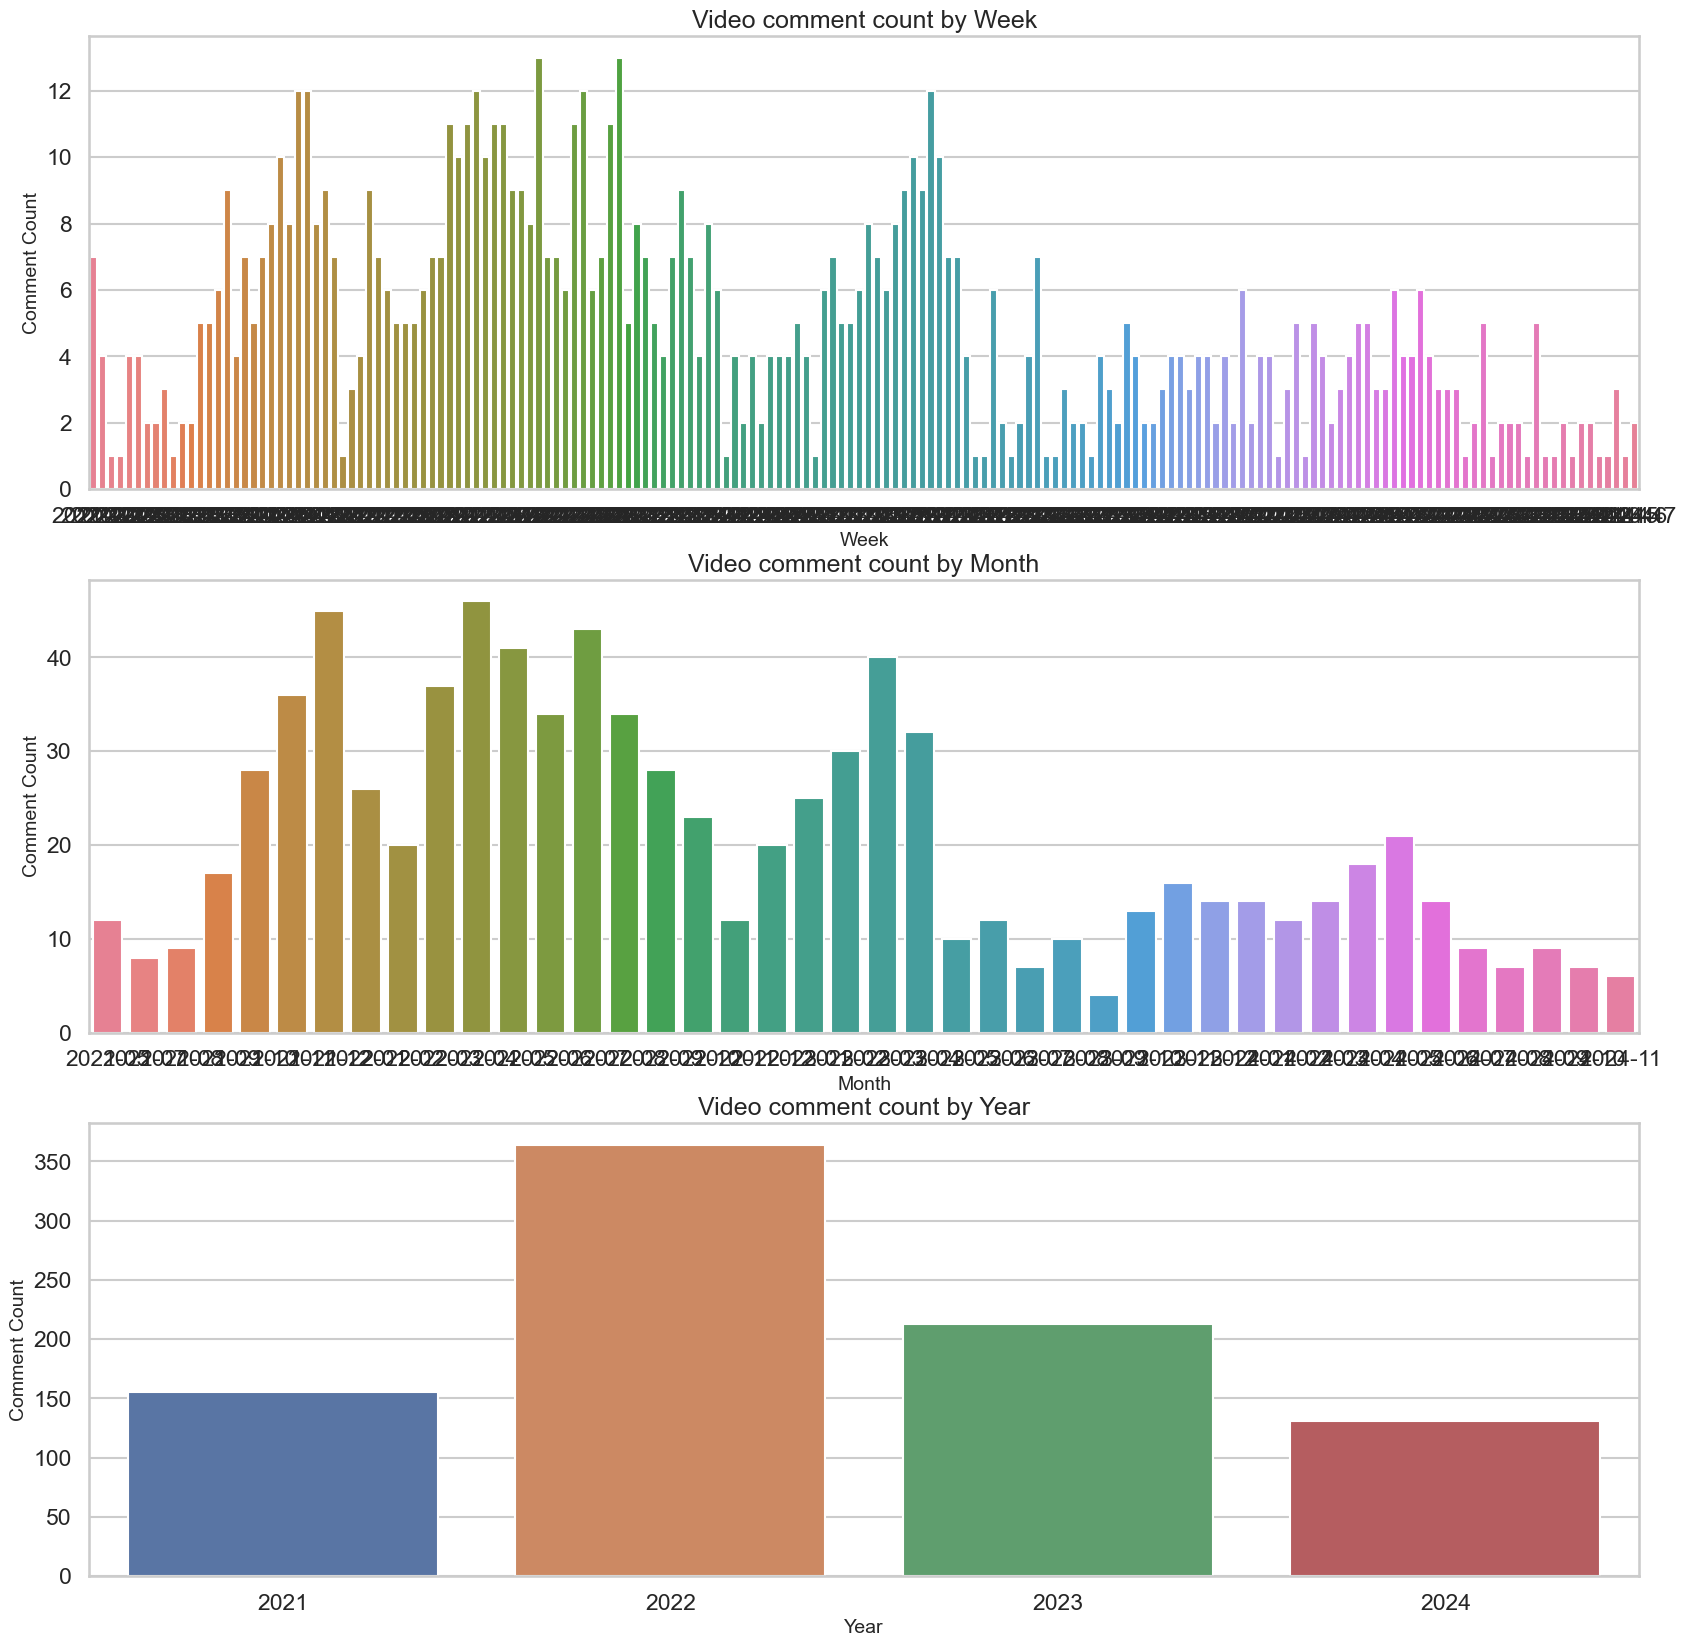

In [70]:
fig, axes = plt.subplots(3,1,figsize = (20,20))
sns.barplot(data= video_comment_by_week, x = 'Week', y='commentCount', ax=axes[0], hue = 'Week')
axes[0].set_xlabel('Week', fontsize = 14)
axes[0].set_ylabel('Comment Count', fontsize = 14)
axes[0].set_title('Video comment count by Week', fontsize =18)

sns.barplot(data= video_comment_by_month, x = 'Month', y='commentCount', ax=axes[1], hue = 'Month')
axes[1].set_xlabel('Month', fontsize = 14)
axes[1].set_ylabel('Comment Count', fontsize = 14)
axes[1].set_title('Video comment count by Month', fontsize =18)

sns.barplot(data= video_comment_by_year, x = 'Year', y='commentCount', ax=axes[2], hue = 'Year')
axes[2].set_xlabel('Year', fontsize = 14)
axes[2].set_ylabel('Comment Count', fontsize = 14)
axes[2].set_title('Video comment count by Year', fontsize =18)

### 2.6 Phân tích tương tác của tài khoản qua lượt Share

In [71]:
share_data = read_df.copy()
print('Tổng số lượt share là: ' + str(share_data['shareCount'].sum()))
print('Trung bình lượt share là: ' + str(share_data['shareCount'].mean()))
print('Trung vị số share là: ' + str(share_data['shareCount'].median()))


Tổng số lượt share là: 601603
Trung bình lượt share là: 697.106604866744
Trung vị số share là: 172.0


In [72]:
#Video có lượt share cao nhất:

share_max_comment = share_data['shareCount'].max()
print_max = share_data[share_data['shareCount'] == share_max_comment]
print_max

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
662,18400,10100,1646044755,2022-02-28 17:39:15+07:00,887000,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,11400000,...,2022-02-28,17,2022,2,28,3,Monday,28,2022-02-28,943100


(18993.0, 20028.0)

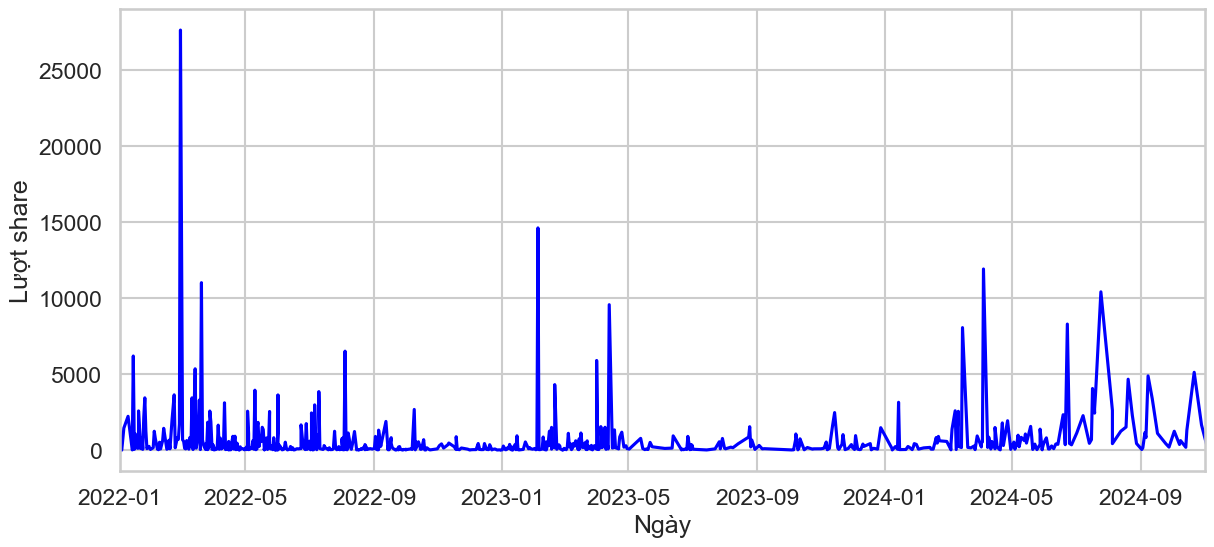

In [73]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(read_df['date'], read_df['shareCount'], color='blue')
ax.set_xlabel('Ngày')
ax.set_ylabel('Lượt share')
ax.set_xlim(pd.to_datetime('2022-01-01'), pd.to_datetime('2024-11-01'))

Biểu đồ cho thấy sự biến động rất lớn, với những đỉnh cao và sụt giảm đột ngột trong số lượng chia sẻ theo thời gian được hiển thị. Có một số đỉnh cao, nơi số lượng chia sẻ vượt quá 20.000, sau đó lại giảm đáng kể.

C:\Users\admin\AppData\Local\Temp\ipykernel_17088\1101668351.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = read_df.groupby(['day_of_week', 'hour'])['shareCount'].sum().unstack()


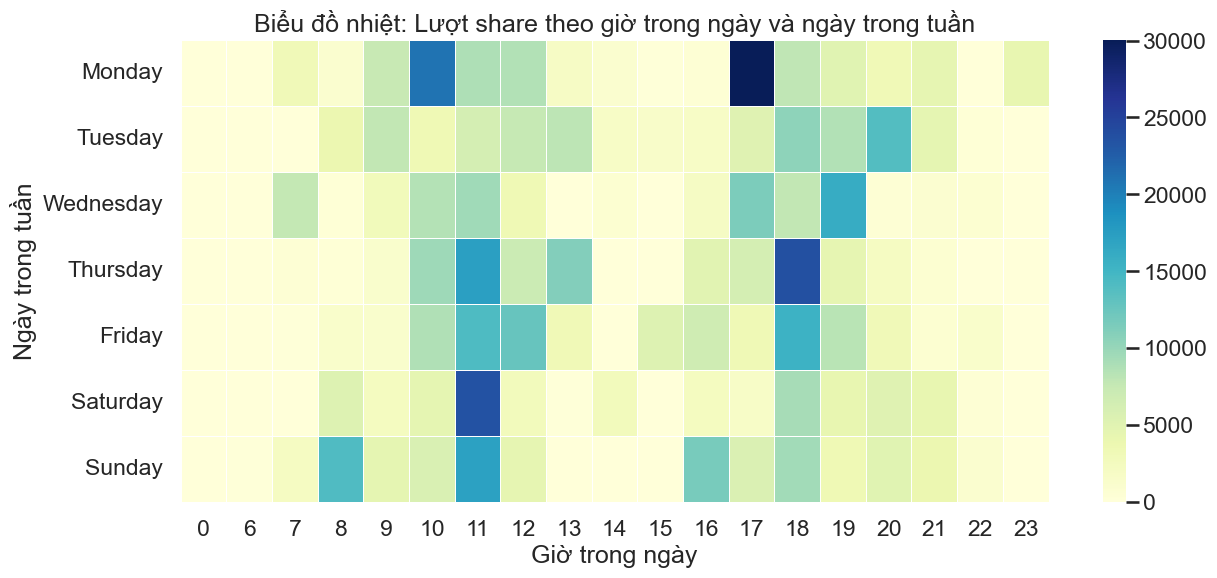

In [74]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
read_df['day_of_week'] = pd.Categorical(read_df['day_of_week'], categories=day_order, ordered=True)
heatmap_data = read_df.groupby(['day_of_week', 'hour'])['shareCount'].sum().unstack()

# Vẽ biểu đồ nhiệt
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', fmt='g', linewidths=0.5)

# Cài đặt nhãn trục và tiêu đề
plt.title('Biểu đồ nhiệt: Lượt share theo giờ trong ngày và ngày trong tuần')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Ngày trong tuần')


# Hiển thị biểu đồ
plt.show()

Từ biểu đồ nhiệt trên, ta có thể dễ dàng nhận thấy lượng tương tác share tập chung chủ yếu vào các khung giờ 10-12h, 17-19 giờ, và nhiều nhất vào thứ hai.

### 2.7 Phân tích tương tác của tài khoản qua lượt Yêu thích (Collect)

In [75]:
# Tính toán các chỉ số: trung bình, độ lệch chuẩn, trung vị, cao nhất và thấp nhất
sum_posts = read_df['collectCount'].sum()
mean_posts = read_df['collectCount'].mean()  # Trung bình
std_posts = read_df['collectCount'].std()    # Độ lệch chuẩn
median_posts = read_df['collectCount'].median()  # Trung vị

# In ra các giá trị tính toán
print(f"Tổng lượt yêu thích: {sum_posts:.2f}")
print(f"Trung bình lượt yêu thích: {mean_posts:.2f}")
print(f"Độ lệch chuẩn của lượt yêu thích: {std_posts:.2f}")
print(f"Trung vị của lượt yêu thích: {median_posts:.2f}")


Tổng lượt yêu thích: 1521732.00
Trung bình lượt yêu thích: 1763.30
Độ lệch chuẩn của lượt yêu thích: 4303.24
Trung vị của lượt yêu thích: 453.00


In [76]:
Collect_data = read_df.copy()
# Video có lượt yêu thích cao nhất:
collect_max = Collect_data['collectCount'].max()  # Tìm giá trị lớn nhất của lượt yêu thích
print_max = Collect_data[Collect_data['collectCount'] == collect_max]  # Lọc dữ liệu với giá trị lớn nhất
print_max


,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
41,60100,5269,1719136744,2024-06-23 16:59:04+07:00,1200000,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,19200000,...,2024-06-23,16,2024,6,23,20,Sunday,23,2024-06-23,1273649


In [77]:
# Video có lượt collect thấp nhất:
collect_min_count = Collect_data['collectCount'].min()
print_min = Collect_data[Collect_data['collectCount'] == collect_min_count]
print_min

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
706,3,42,1641204007,2022-01-03 17:00:07+07:00,2925,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,84100,...,2022-01-03,17,2022,1,3,3,Monday,3,2022-01-03,2971
844,3,38,1627665912,2021-07-31 00:25:12+07:00,1158,NaN,dongmauviet,vietnam,DÃ²ng MÃ¡u Viá»t,45400,...,2021-07-31,0,2021,7,31,10,Saturday,31,2021-07-31,1200


In [78]:
#Top 10 video có lượt yêu thích nhiều nhất

top_10 = Collect_data.nlargest(10, 'collectCount')
top_10

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
41,60100,5269,1719136744,2024-06-23 16:59:04+07:00,1200000,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,19200000,...,2024-06-23,16,2024,6,23,20,Sunday,23,2024-06-23,1273649
485,40000,7841,1657462959,2022-07-10 21:22:39+07:00,1100000,dongmauviet,dcgr,vietnam,DÃ²ng MÃ¡u Viá»t,10500000,...,2022-07-10,21,2022,7,10,3,Sunday,10,2022-07-10,1151683
29,39600,4812,1721888128,2024-07-25 13:15:28+07:00,794200,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,8500000,...,2024-07-25,13,2024,7,25,12,Thursday,25,2024-07-25,849012
96,35800,7120,1710482040,2024-03-15 12:54:00+07:00,750400,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,20100000,...,2024-03-15,12,2024,3,15,15,Friday,15,2024-03-15,801369
87,33400,8603,1712228567,2024-04-04 18:02:47+07:00,559900,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,9500000,...,2024-04-04,18,2024,4,4,11,Thursday,4,2024-04-04,613803
229,27200,5692,1681358945,2023-04-13 11:09:05+07:00,639900,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,9600000,...,2023-04-13,11,2023,4,13,3,Thursday,13,2023-04-13,682345
330,23000,1181,1673782145,2023-01-15 18:29:05+07:00,465600,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,4500000,...,2023-01-15,18,2023,1,15,3,Sunday,15,2023-01-15,490721
247,21800,14800,1680349705,2023-04-01 18:48:25+07:00,672200,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,8300000,...,2023-04-01,18,2023,4,1,3,Saturday,1,2023-04-01,714689
315,20200,4237,1675484775,2023-02-04 11:26:15+07:00,237100,dongmauviet,dcgr,vietnam,DÃ²ng MÃ¡u Viá»t,3300000,...,2023-02-04,11,2023,2,4,3,Saturday,4,2023-02-04,276137
24,19900,5160,1724133888,2024-08-20 13:04:48+07:00,253400,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,5200000,...,2024-08-20,13,2024,8,20,17,Tuesday,20,2024-08-20,283119


In [79]:
# Đếm số lượt yêu thích theo tuần
video_collect_by_week = pd.DataFrame()
video_collect_by_week['Week'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%W')
video_collect_by_week = video_collect_by_week.sort_values('Week')
video_collect_by_week = video_collect_by_week.groupby('Week').size().reset_index(name='collectCount')

# Đếm số lượt yêu thích theo tháng
video_collect_by_month = pd.DataFrame()
video_collect_by_month['Month'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%m')
video_collect_by_month = video_collect_by_month.sort_values('Month')
video_collect_by_month = video_collect_by_month.groupby('Month').size().reset_index(name='collectCount')

# Đếm số lượt yêu thích theo năm
video_collect_by_year = pd.DataFrame()
video_collect_by_year['Year'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y')
video_collect_by_year = video_collect_by_year.sort_values('Year')
video_collect_by_year = video_collect_by_year.groupby('Year').size().reset_index(name='collectCount')


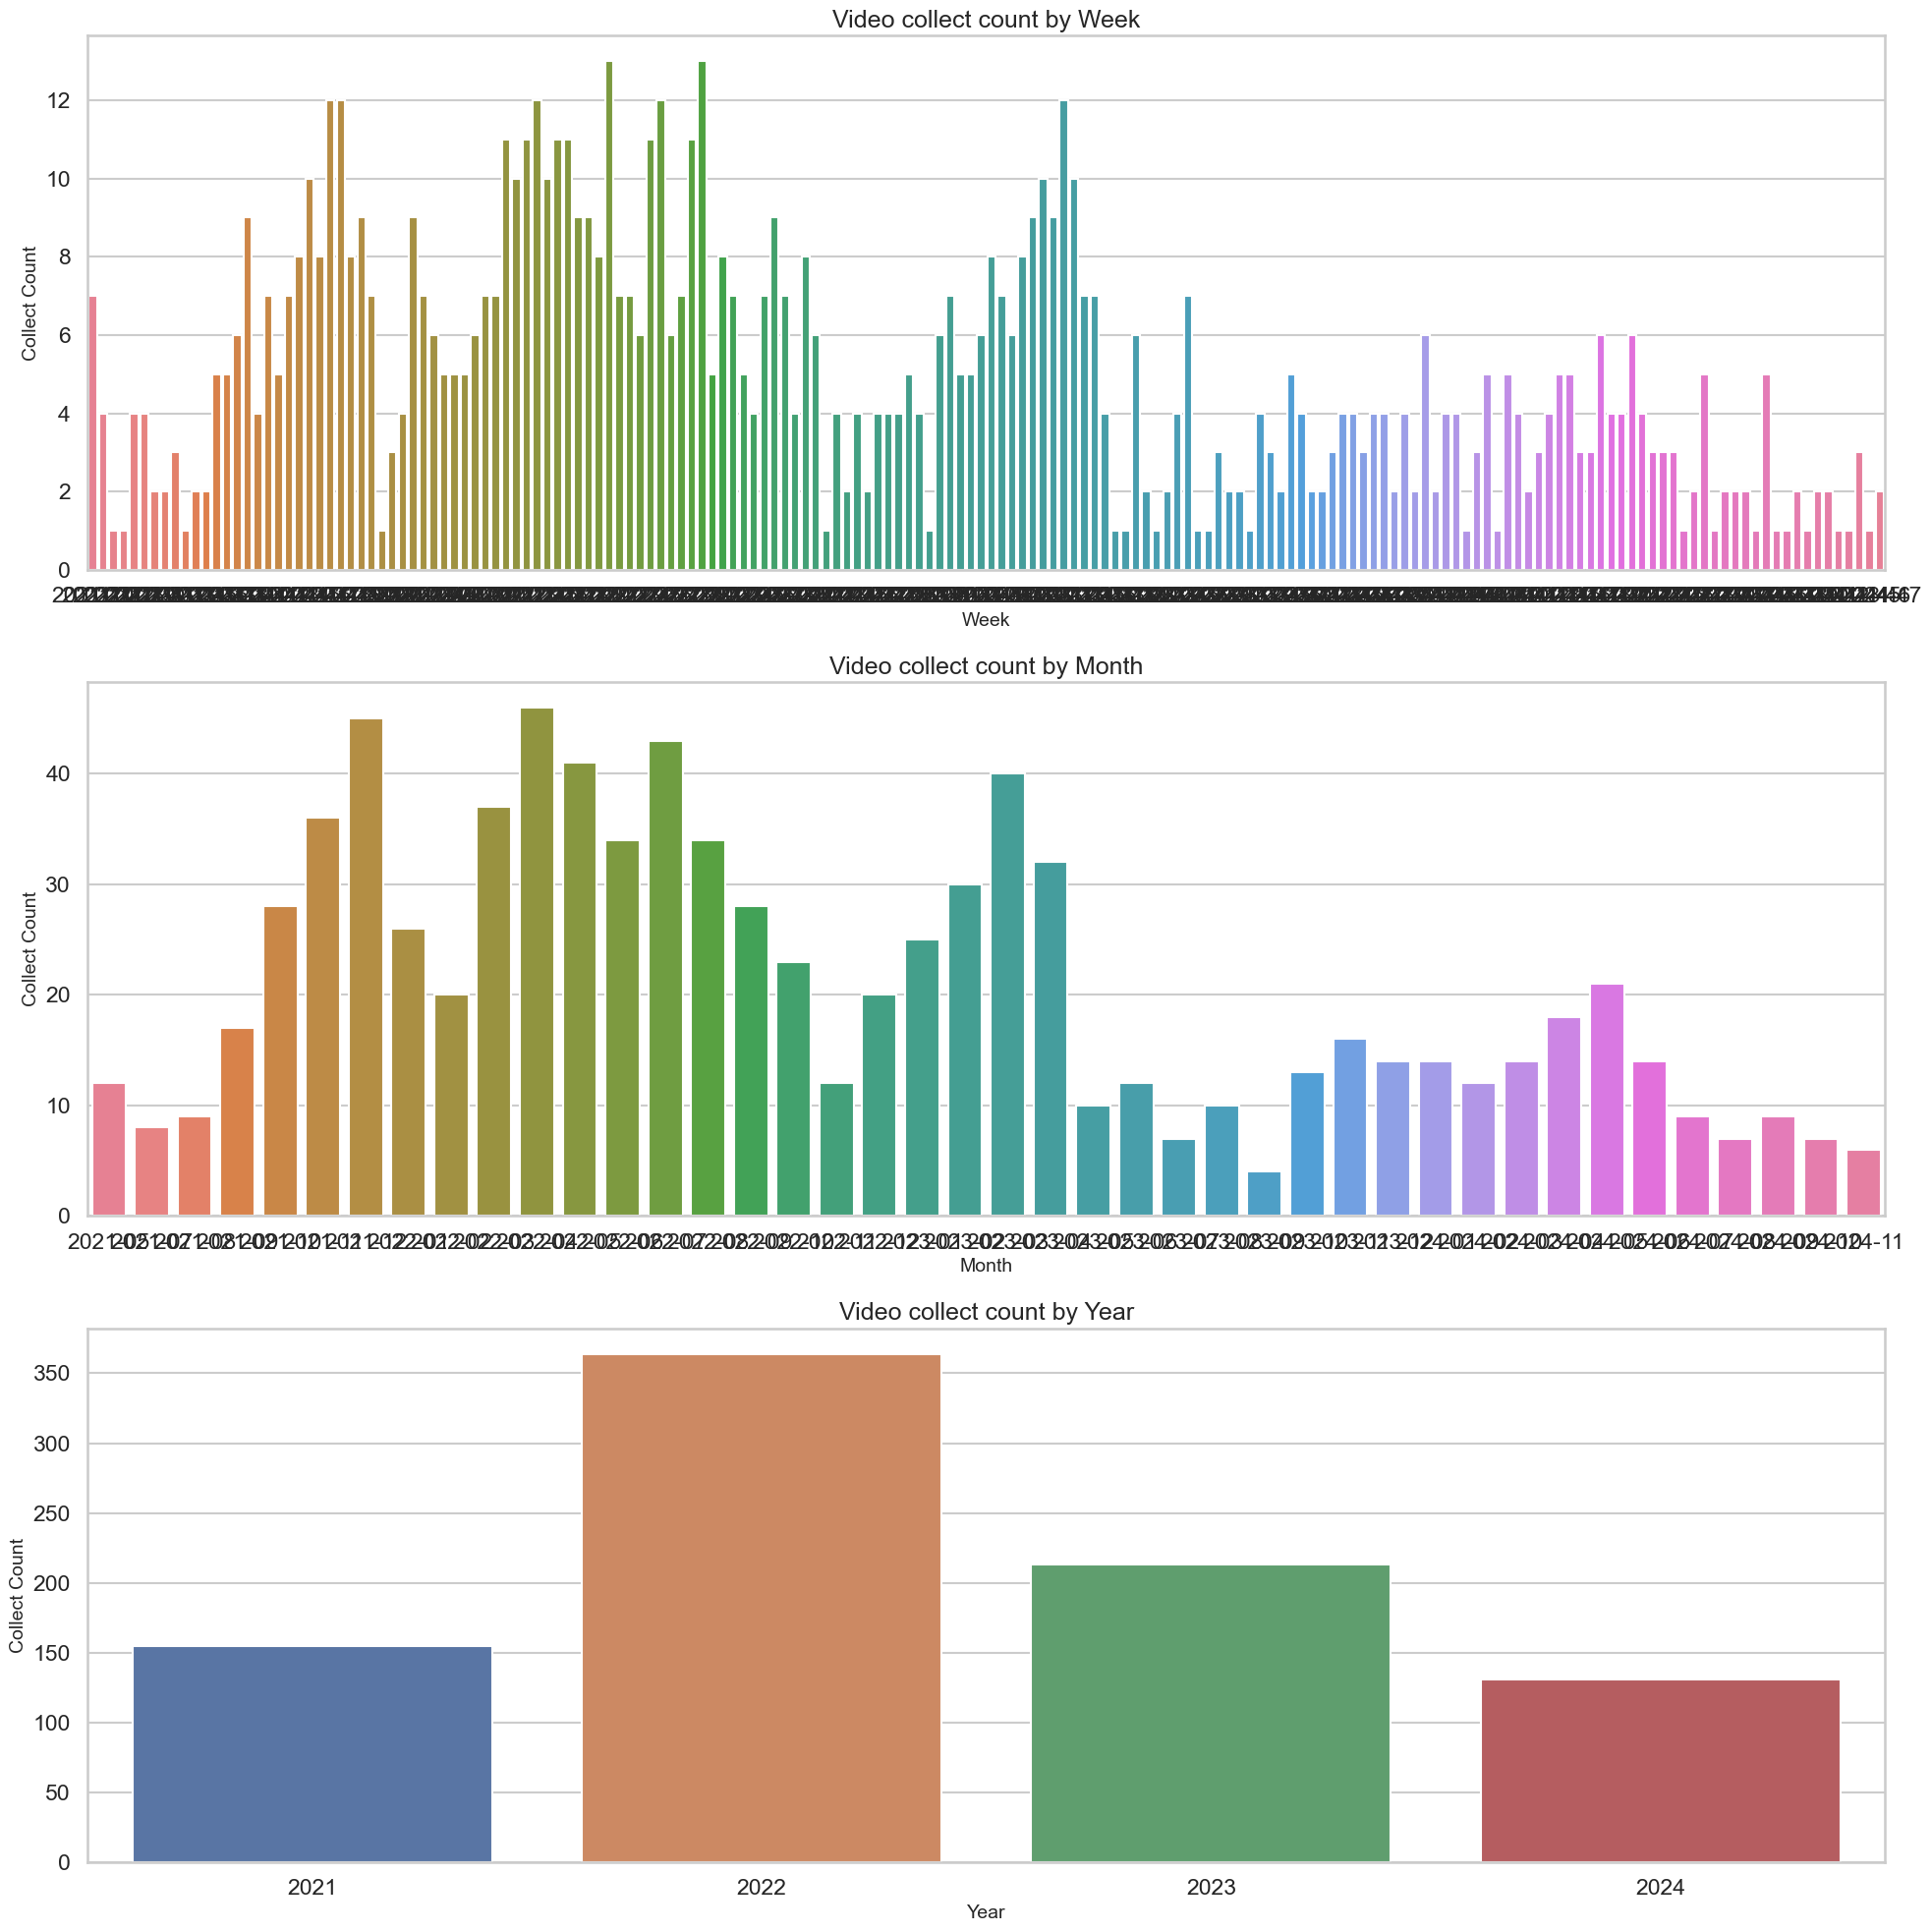

In [80]:
from matplotlib.ticker import FuncFormatter

# Hàm định dạng số dạng rút gọn
def format_number_short(x, _):
    if x >= 1_000_000:
        return f"{x / 1_000_000:.1f}M"
    elif x >= 1_000:
        return f"{x / 1_000:.1f}K"
    else:
        return str(int(x))

fig, axes = plt.subplots(3, 1, figsize=(20, 20))

# Biểu đồ lượt yêu thích theo tuần
sns.barplot(data=video_collect_by_week, x='Week', y='collectCount', ax=axes[0], hue='Week')
axes[0].set_xlabel('Week', fontsize=14)
axes[0].set_ylabel('Collect Count', fontsize=14)
axes[0].set_title('Video collect count by Week', fontsize=18)
axes[0].yaxis.set_major_formatter(FuncFormatter(format_number_short))

# Biểu đồ lượt yêu thích theo tháng
sns.barplot(data=video_collect_by_month, x='Month', y='collectCount', ax=axes[1], hue='Month')
axes[1].set_xlabel('Month', fontsize=14)
axes[1].set_ylabel('Collect Count', fontsize=14)
axes[1].set_title('Video collect count by Month', fontsize=18)
axes[1].yaxis.set_major_formatter(FuncFormatter(format_number_short))

# Biểu đồ lượt yêu thích theo năm
sns.barplot(data=video_collect_by_year, x='Year', y='collectCount', ax=axes[2], hue='Year')
axes[2].set_xlabel('Year', fontsize=14)
axes[2].set_ylabel('Collect Count', fontsize=14)
axes[2].set_title('Video collect count by Year', fontsize=18)
axes[2].yaxis.set_major_formatter(FuncFormatter(format_number_short))

plt.tight_layout()
plt.show()


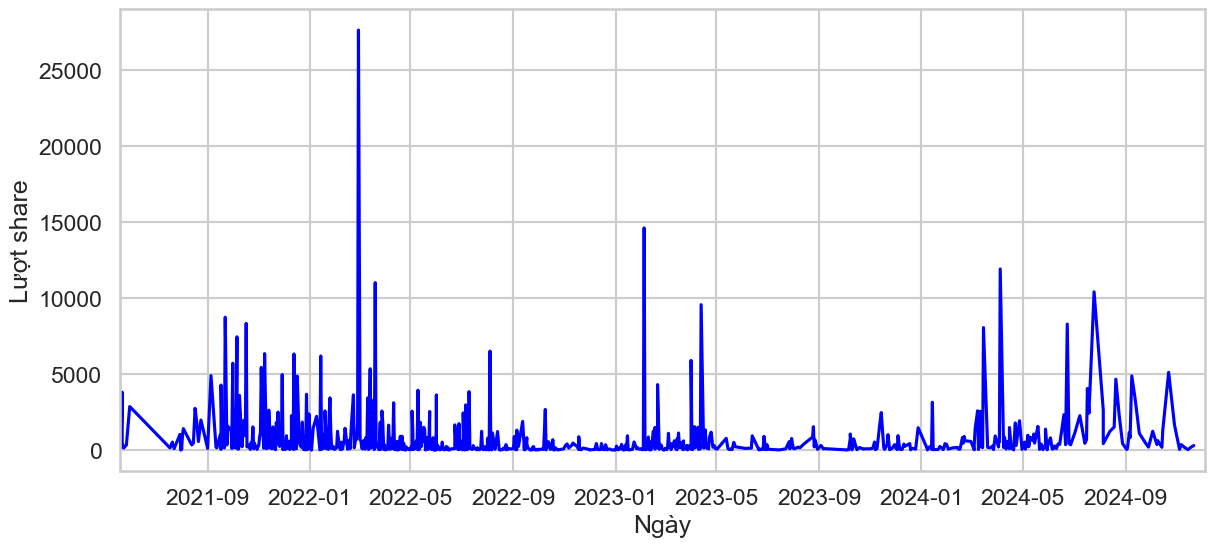

In [81]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(read_df['date'], read_df['shareCount'], color='blue')
ax.set_xlabel('Ngày')
ax.set_ylabel('Lượt share')

# Thiết lập xlim từ ngày sớm nhất trong dữ liệu đến hiện tại
ax.set_xlim(pd.to_datetime(read_df['date'].min()), pd.Timestamp.now())

plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_17088\3374108132.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = filtered_df.groupby(['day_of_week', 'hour'])['collectCount'].sum().unstack()


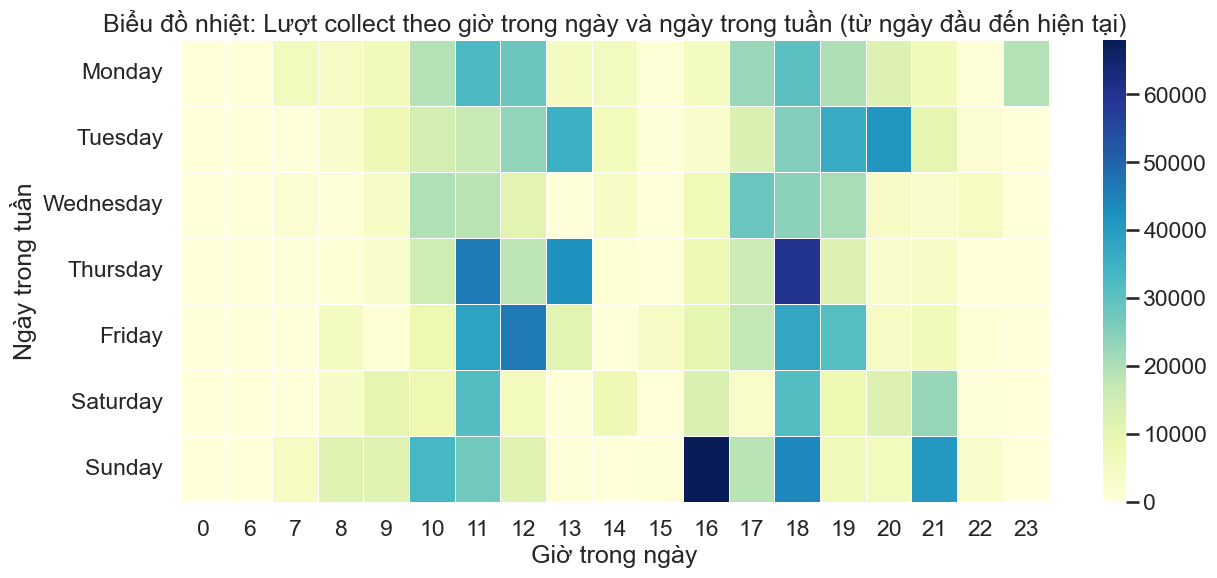

In [82]:
# Định nghĩa thứ tự ngày trong tuần
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
read_df['day_of_week'] = pd.Categorical(read_df['day_of_week'], categories=day_order, ordered=True)

# Lọc dữ liệu theo khoảng thời gian từ ngày đầu tiên đến hiện tại
start_date = pd.to_datetime(read_df['date'].min())
end_date = pd.Timestamp.now()
filtered_df = read_df[(read_df['date'] >= start_date) & (read_df['date'] <= end_date)]

# Chuẩn bị dữ liệu cho biểu đồ nhiệt
heatmap_data = filtered_df.groupby(['day_of_week', 'hour'])['collectCount'].sum().unstack()

# Vẽ biểu đồ nhiệt
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', fmt='g', linewidths=0.5)

# Cài đặt nhãn trục và tiêu đề
plt.title('Biểu đồ nhiệt: Lượt collect theo giờ trong ngày và ngày trong tuần (từ ngày đầu đến hiện tại)')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Ngày trong tuần')

# Hiển thị biểu đồ
plt.show()


## 3. Phân tích sự tương quan giữa các yếu tố

### 3.1 Tương quan giữa commentCount, shareCount, diggCount và playCount 

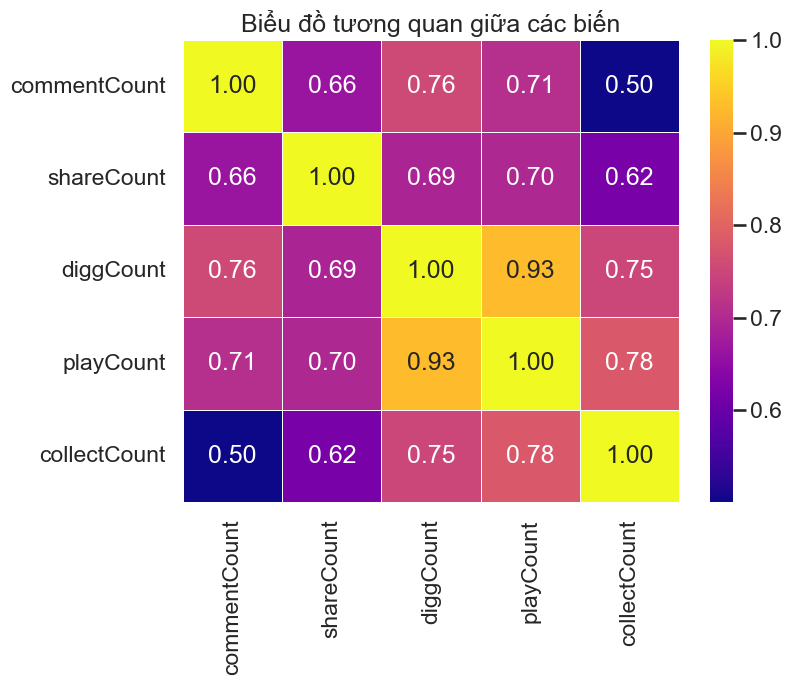

In [83]:
corr_row=read_df[['commentCount','shareCount','diggCount','playCount','collectCount']]
correlation_matrix = corr_row.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='plasma', fmt=".2f", linewidths=0.5)
plt.title('Biểu đồ tương quan giữa các biến')
plt.show()

Từ biểu đồ tương quan trên, ta dễ dàng nhận thấy các yếu tố về tương tác có sự liên hệ mật thiết với nhau:
- Lượt xem và lượt thích có độ tương quan cao nhất với: 0.93
- Lượt xem và lượt lưu: 0.78
- Lượt comment và lượt thích: 0.76
- Lượt lưu và lượt thích: 0.75
- Lượt xem và lượt lưu: 0.70
- Lượt thích và lượt chia sẻ: 0.69
- Lượt comment và lượt chia sẻ: 0.66
- lượt share và lượt lưu: 0.63
- Lượt bình luận và lượt lưu: 0.50

### 3.2 Phân tích mối tương quan giữa giờ đăng và tương tác

In [84]:
rate_of_reaction_by_hour = rate_reaction.groupby('hour')['ER'].mean().reset_index()
full_hours = pd.DataFrame({'hour': range(24)}) 
rate_of_reaction_by_hour = full_hours.merge(rate_of_reaction_by_hour, on='hour', how='left')
rate_of_reaction_by_hour['ER'] = rate_of_reaction_by_hour['ER'].fillna(0)  

rate_of_reaction_by_hour


,hour,ER
0,0,2.636564
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,6.260000
7,7,7.727228
8,8,7.789815
9,9,7.366548


C:\Users\admin\AppData\Local\Temp\ipykernel_17088\775002183.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rate_of_reaction_by_hour, x='hour', y='ER', palette='Blues_d')


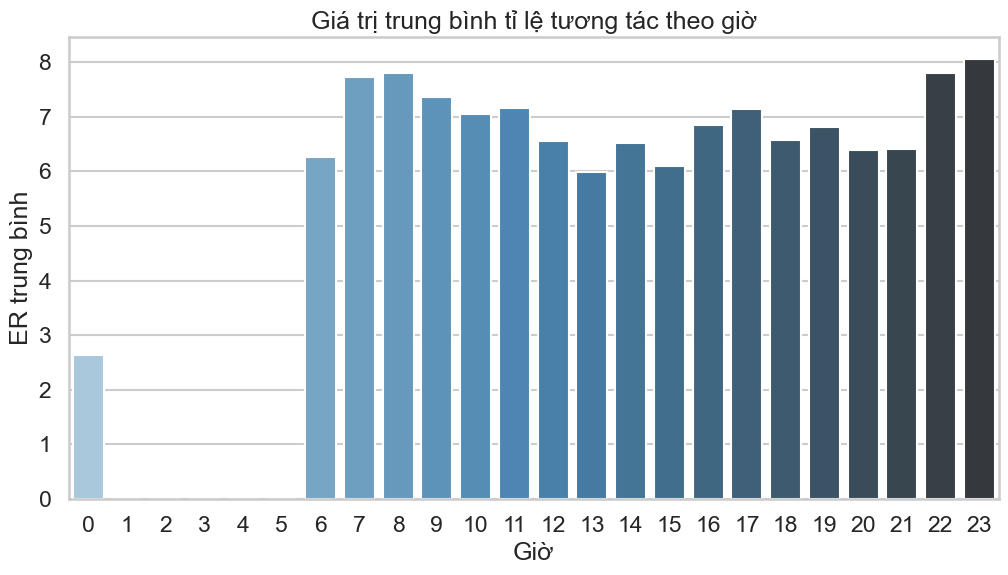

In [85]:
rate_of_reaction_by_hour = rate_reaction.groupby('hour')['ER'].mean().reset_index()
full_hours = pd.DataFrame({'hour': range(24)}) 
rate_of_reaction_by_hour = full_hours.merge(rate_of_reaction_by_hour, on='hour', how='left')
rate_of_reaction_by_hour['ER'] = rate_of_reaction_by_hour['ER'].fillna(0)  

plt.figure(figsize=(12, 6))  
sns.barplot(data=rate_of_reaction_by_hour, x='hour', y='ER', palette='Blues_d')

plt.title('Giá trị trung bình tỉ lệ tương tác theo giờ')
plt.xlabel('Giờ')
plt.ylabel('ER trung bình')
plt.xticks(range(0, 24))  
plt.show()



Ta có thể thấy được rằng: khung giờ 22-23 giờ: Đây là khung giờ có tỷ lệ tương tác cao nhất. Điều này có thể gợi ý rằng người dùng hoạt động tích cực vào buổi đêm, lúc mọi người nghỉ ngơi, giải trí sau một ngày dài làm việc, bên cạnh đó khung giờ 7-8h sáng cũng có lượt tương tác cao không kém.
Buổi chiều và tối (13-23 giờ): Tỷ lệ tương tác duy trì ổn định nhưng không cao như khung giờ sáng.
Nửa đêm đến sáng sớm (0-5 giờ): Tương tác thấp nhất, có thể do người dùng ít hoạt động trong khoảng thời gian này.


### 3.3 So sánh tương quan giữa thời lượng video và tỉ lệ tương tác

In [86]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype                           
---  ------                                --------------  -----                           
 0   collectCount                          863 non-null    int64                           
 1   commentCount                          863 non-null    int64                           
 2   createTime                            863 non-null    int64                           
 3   createTimeISO                         863 non-null    datetime64[ns, Asia/Ho_Chi_Minh]
 4   diggCount                             863 non-null    int64                           
 5   hashtags/0/name                       835 non-null    object                          
 6   hashtags/1/name                       813 non-null    object                          
 7   hashtags/2/name                       674 non-null    object  

In [87]:
vd = rate_reaction.copy()
vd['videoMeta/duration'] = read_df['videoMeta/duration']
vd

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount,ER
0,1392,231,1732165470,2024-11-21 12:04:30+07:00,26900,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,499600,...,12,2024,11,21,14,Thursday,21,2024-11-21,28822,5.490392
1,275,45,1731913011,2024-11-18 13:56:51+07:00,3128,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,33600,...,13,2024,11,18,11,Monday,18,2024-11-18,3651,10.047619
2,184,34,1731554729,2024-11-14 10:25:29+07:00,3192,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,36300,...,10,2024,11,14,11,Thursday,14,2024-11-14,3441,8.972452
3,691,226,1731216293,2024-11-10 12:24:53+07:00,17700,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,305200,...,12,2024,11,10,13,Sunday,10,2024-11-10,18793,5.931193
4,1544,708,1730886398,2024-11-06 16:46:38+07:00,38300,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,1000000,...,16,2024,11,6,9,Wednesday,6,2024-11-06,40916,3.937200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,641,2285,1621612142,2021-05-21 22:49:02+07:00,150200,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,1300000,...,22,2021,5,21,26,Friday,21,2021-05-21,154190,11.811462
859,125,282,1621556153,2021-05-21 07:15:53+07:00,16200,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,145000,...,7,2021,5,21,19,Friday,21,2021-05-21,16762,11.473793
860,407,1195,1621471433,2021-05-20 07:43:53+07:00,73700,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,434800,...,7,2021,5,20,23,Thursday,20,2021-05-20,75595,17.292548
861,248,77,1621385927,2021-05-19 07:58:47+07:00,14000,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,139000,...,7,2021,5,19,23,Wednesday,19,2021-05-19,14463,10.226619


In [88]:
top10 = vd.nlargest(10, 'ER')
top10[['videoMeta/duration', 'ER']]

,videoMeta/duration,ER
788,93,17.406996
860,68,17.292548
813,159,15.424242
620,49,14.770294
803,113,14.523152
845,79,14.449200
232,157,14.226866
792,71,14.045244
553,62,14.040165
819,99,13.876485


In [89]:
top10_ = vd.nsmallest(10,'ER')
top10_[['videoMeta/duration', 'ER']]

,videoMeta/duration,ER
358,51,1.400833
240,152,1.760740
99,58,1.886023
238,88,1.948647
152,42,2.188518
138,46,2.198706
127,50,2.244070
169,144,2.506273
844,82,2.636564
115,43,2.657005


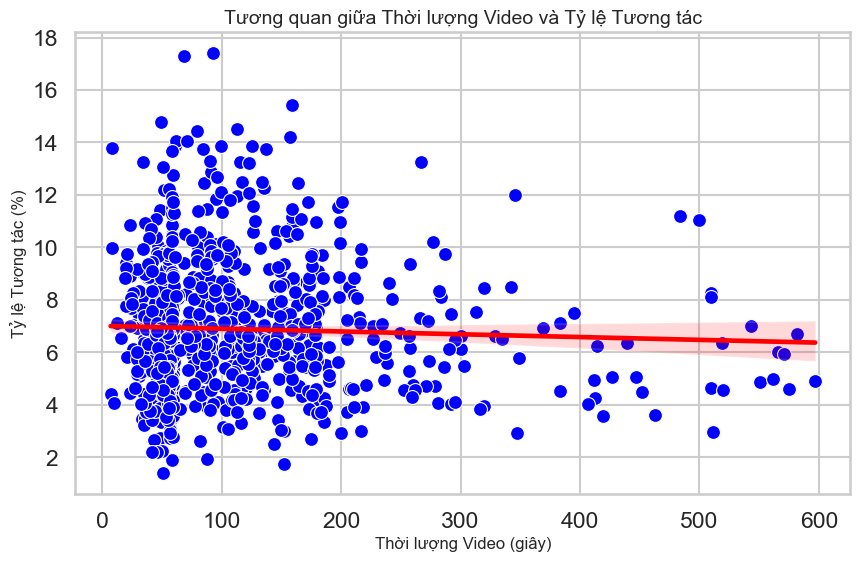

In [90]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vd, x='videoMeta/duration', y='ER', color='blue', s=100)

sns.regplot(data=vd, x='videoMeta/duration', y='ER', scatter=False, color='red')
plt.title('Tương quan giữa Thời lượng Video và Tỷ lệ Tương tác', fontsize=14)
plt.xlabel('Thời lượng Video (giây)', fontsize=12)
plt.ylabel('Tỷ lệ Tương tác (%)', fontsize=12)
plt.grid(True)

plt.show()

Đường xu hướng màu đỏ (trendline) biểu thị mối tương quan giữa thời lượng video và tỷ lệ tương tác. Đường này dốc xuống rất nhẹ, cho thấy có mối tương quan âm yếu giữa thời lượng video và tỷ lệ tương tác. Điều này có nghĩa là:
Khi thời lượng video tăng, tỷ lệ tương tác có xu hướng giảm, nhưng mức giảm không lớn.

### 3.6 Từ phổ biến trong bài đăng

- Tách title từ caption bỏ hastag

In [91]:
read_df['title'] = read_df['text'].apply(
    lambda x: re.match(r'^(.*?)(?:\s*#|$)', x).group(1).strip() if isinstance(x, str) else x
)

# Hiển thị kết quả
print(read_df[['title']])


                                                 title
0              4 Vị Tướng Cúi Đầu Trước 1 Vị Trung Tá.
1                Lịch Sử Ngày Nhà Giáo Việt Nam 20/11.
2                    Chiếc Mũ Huyền Thoại Của Ông Cha.
3                         Mẹ Thứ, Hơn Cả Sự Vĩ Đại ...
4                                Phép Màu Việt Nam ...
..                                                 ...
858  Mọi người vào kênh youtube : dòng máu Việt để ...
859  Xin mọi người 1 bình luận để kênh lấy lại tươn...
860  Xin mỗi người 1 chấm vào bình luận để kênh lấy...
861  Mọi người cho mình xin 1 chấm vào bình luận để...
862  dòng máu Việt - trở lạiXin 1 chấm vào phần bìn...

[863 rows x 1 columns]


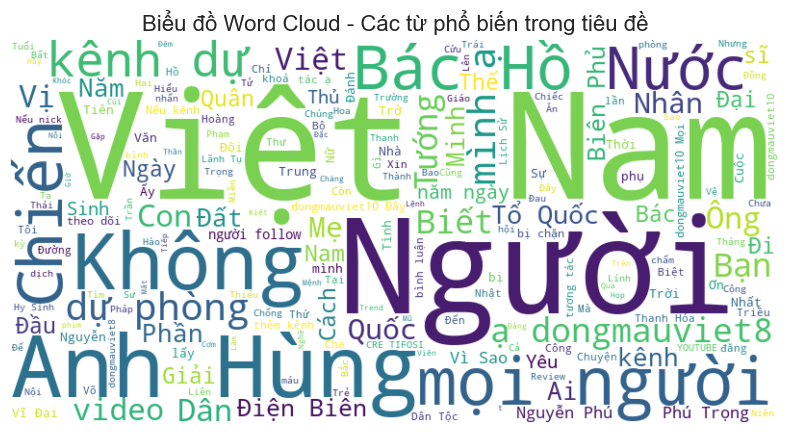

In [92]:
from wordcloud import WordCloud, STOPWORDS

# Đọc dữ liệu (giả định read_df đã được nạp)
text_data = " ".join(read_df['title'].dropna())  # Ghép tất cả các tiêu đề lại thành một chuỗi lớn

# Danh sách từ dừng tiếng Việt (có thể mở rộng tùy ý)
vietnamese_stopwords = {"là", "và", "của", "một", "những", "có", "được", "trong", "với", 
                        "này", "các", "cho", "để", "khi", "đã", "từ", "ra", "vào", "sẽ", 
                        "thì", "như", "về", "lại", "nhiều", "đó", "nên", "hơn", "nữa", "ở", "nơi"}

# Mở rộng từ dừng của WordCloud với từ dừng tiếng Việt
stopwords = STOPWORDS.union(vietnamese_stopwords)

# Tạo WordCloud với font hỗ trợ tiếng Việt
wordcloud = WordCloud(width=800, height=400, background_color="white", 
                      colormap="viridis", stopwords=stopwords).generate(text_data)

# Vẽ biểu đồ WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Biểu đồ Word Cloud - Các từ phổ biến trong tiêu đề", fontsize=16)
plt.show()

## 4. Xây dựng mô hình dự đoán dựa trên PCA, học máy

In [93]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


data1= pd.DataFrame(read_df[['collectCount','commentCount','shareCount','diggCount','playCount']])
data1.info()

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data1)

# Áp dụng PCA
pca = PCA(n_components=1)  # Giảm xuống 2 thành phần chính
principal_components = pca.fit_transform(data_scaled)

# Xem tỷ lệ phương sai giải thích
print("Tỷ lệ phương sai giải thích của các thành phần chính:")
print(pca.explained_variance_ratio_)

# Hiển thị hệ số tải
loadings = pd.DataFrame(pca.components_, columns=['collectCount','commentCount','shareCount','diggCount','playCount'], index=['PC1'])
print("Hệ số tải (Loadings):")
print(loadings)

ModuleNotFoundError: No module named 'sklearn'

Kiểm tra tính tuyến tính của tập dữ liệu đầu vào và mục tiêu

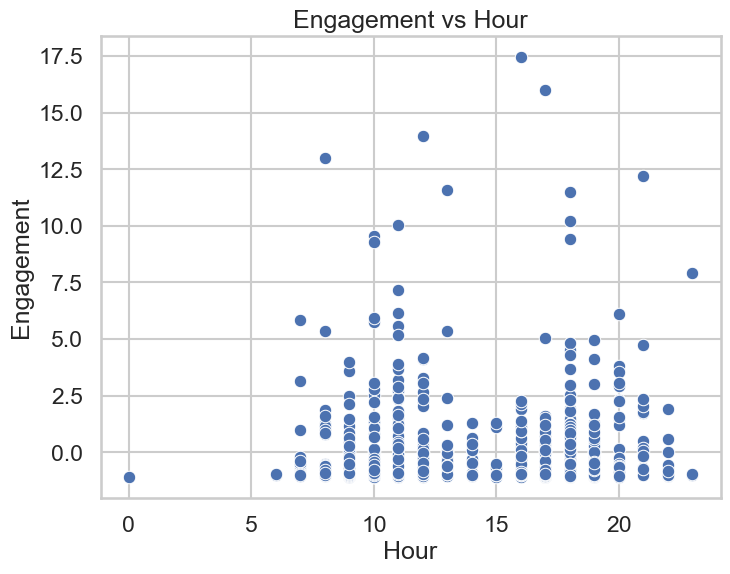

In [ ]:
PCA = pd.DataFrame(principal_components, columns=['PC1'])
PCA['input']=read_df['hour']
plt.figure(figsize=(8, 6))
sns.scatterplot(data=PCA, x='input', y='PC1')
plt.title('Engagement vs Hour')
plt.xlabel('Hour')
plt.ylabel('Engagement')
plt.show()

Dựa vào biểu đồ trên, ta thấy mối quan hệ giữa giờ đăng bài và Hiệu suất video là không tuyến tính => Không thể dùng mô hình hồi quy tuyến tính trong việc dự đoán hiệu suất của video mới.

Thử dùng Random Forest

In [ ]:
read_df['hashtag_count'] = read_df[['hashtags/0/name', 'hashtags/1/name', 'hashtags/2/name']].notna().sum(axis=1)
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype                           
---  ------                                --------------  -----                           
 0   collectCount                          863 non-null    int64                           
 1   commentCount                          863 non-null    int64                           
 2   createTime                            863 non-null    int64                           
 3   createTimeISO                         863 non-null    datetime64[ns, Asia/Ho_Chi_Minh]
 4   diggCount                             863 non-null    int64                           
 5   hashtags/0/name                       835 non-null    object                          
 6   hashtags/1/name                       813 non-null    object                          
 7   hashtags/2/name                       674 non-null    object  

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

# Giả sử bạn có một DataFrame 'read_df' với các đặc trưng và 'PCA' chứa giá trị mục tiêu
read_df['date'] = pd.to_datetime(read_df['date'])  # Đảm bảo cột 'date' là kiểu datetime
read_df['wed'] = read_df['date'].dt.dayofweek  # Mã hóa ngày trong tuần

X = read_df[['hour', 'videoMeta/duration', 'hashtag_count']]  # Các đặc trưng đầu vào
y = PCA['PC1']  # Tương tác (mục tiêu)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Khởi tạo mô hình KNN
knn_model = KNeighborsRegressor(n_neighbors=7)

# Huấn luyện mô hình
knn_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_knn = knn_model.predict(X_test)

# Đánh giá mô hình
r2_knn = r2_score(y_test, y_pred_knn)
print("R² (KNN):", r2_knn)

mse_knn = mean_squared_error(y_test, y_pred_knn)
print("MSE (KNN):", mse_knn)


R² (KNN): 0.030637384632390186
MSE (KNN): 5.528498316639855


In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=7, metric='manhattan')  # Thử Manhattan
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print("R² (Manhattan):", r2_score(y_test, y_pred_knn))

R² (Manhattan): 0.0369239733095037


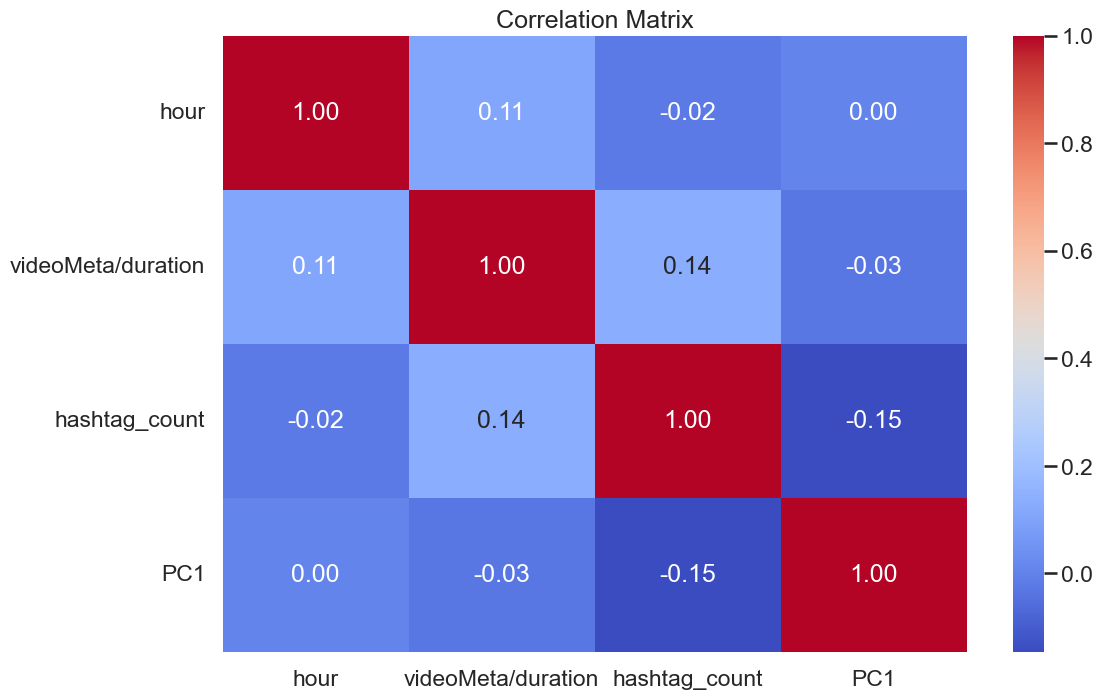

PC1                   1.000000
hour                  0.003698
videoMeta/duration   -0.031135
hashtag_count        -0.145358
Name: PC1, dtype: float64


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

c=pd.DataFrame(read_df[['hour', 'videoMeta/duration', 'hashtag_count']])
c['PC1']=PCA['PC1']
correlation_matrix = c.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

print(correlation_matrix['PC1'].sort_values(ascending=False))
